In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from scipy.optimize import curve_fit

# Graphing
from graph_config import plt
import seaborn as sns

import tqdm as tqdm

from pathlib import Path
import sys

NOTEBOOK_PATH = Path(__file__).resolve() if '__file__' in globals() else Path().resolve()

PROJECT_ROOT = NOTEBOOK_PATH.parent

# Define path to the dataset folder
RAW_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'raw'
PROCESSED_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'processed'

# Define path to output folder
FIGURES_PATH = PROJECT_ROOT / '04_outputs' / '01_figures'
TABLES_PATH = PROJECT_ROOT / '04_outputs' / '02_tables'

# Script paths
SCRIPTS_PATH = PROJECT_ROOT / '03_scripts'


# Turbine Data

In [2]:
def load_data(filename):
    return pd.read_csv(RAW_DATASET_PATH / filename)

df_tt_og = load_data('Turbine_telemetry.csv')

df_tt_og['Timestamp'] = pd.to_datetime(df_tt_og['Timestamp'])

df_tt = df_tt_og.copy()

ts_tt = df_tt.set_index('Timestamp').copy()

In [3]:
df_tt.head()

Timestamp  Power_kw  Setpoint_kw  Wind_ms
0 2015-05-28 00:00:23      80.0        900.0      4.9
1 2015-05-28 00:01:23      78.0        900.0      5.4
2 2015-05-28 00:02:23      52.0        900.0      4.9
3 2015-05-28 00:03:23      57.0        900.0      4.6
4 2015-05-28 00:04:23      54.0        900.0      4.6

In [4]:
df_tt.describe()

Timestamp      Power_kw   Setpoint_kw       Wind_ms
count                        1069636  1.066934e+06  1.066921e+06  1.066931e+06
mean   2016-12-17 14:05:24.329415936  3.671871e+02  8.106578e+02  9.955093e+00
min              2015-05-28 00:00:23  0.000000e+00  0.000000e+00  0.000000e+00
25%              2016-06-06 20:07:01  5.100000e+01  9.000000e+02  6.100000e+00
50%              2016-12-14 22:38:54  2.510000e+02  9.000000e+02  9.000000e+00
75%              2017-07-08 18:32:06  7.040000e+02  9.000000e+02  1.240000e+01
max              2018-01-11 06:14:32  9.380000e+02  9.000000e+02  4.720000e+01
std                              NaN  3.399636e+02  2.615071e+02  5.453944e+00

### Initial Data Time Range

In [5]:
print(f'Min Timestamp: {df_tt["Timestamp"].min()}')
print(f'Max Timestamp: {df_tt["Timestamp"].max()}')

Min Timestamp: 2015-05-28 00:00:23
Max Timestamp: 2018-01-11 06:14:32


## Missing Values

In [6]:
print("Missing values in Turbine Data:")
pd.DataFrame(ts_tt.isna().sum()).rename(columns={0: 'Missing values'}).T


Missing values in Turbine Data:


Power_kw  Setpoint_kw  Wind_ms
Missing values      2702         2715     2705

<Axes: xlabel='Timestamp'>

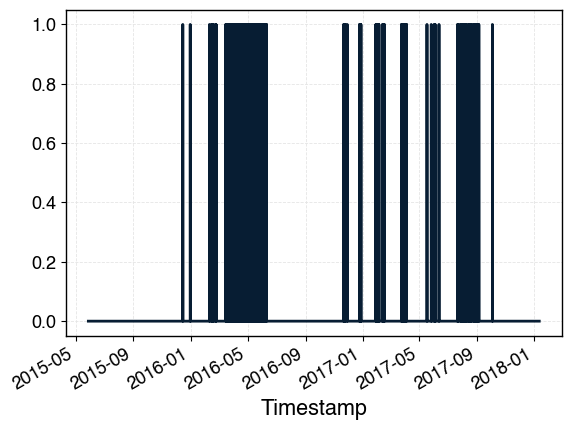

In [7]:
ts_tt['Power_kw'].isna().astype(float).plot()

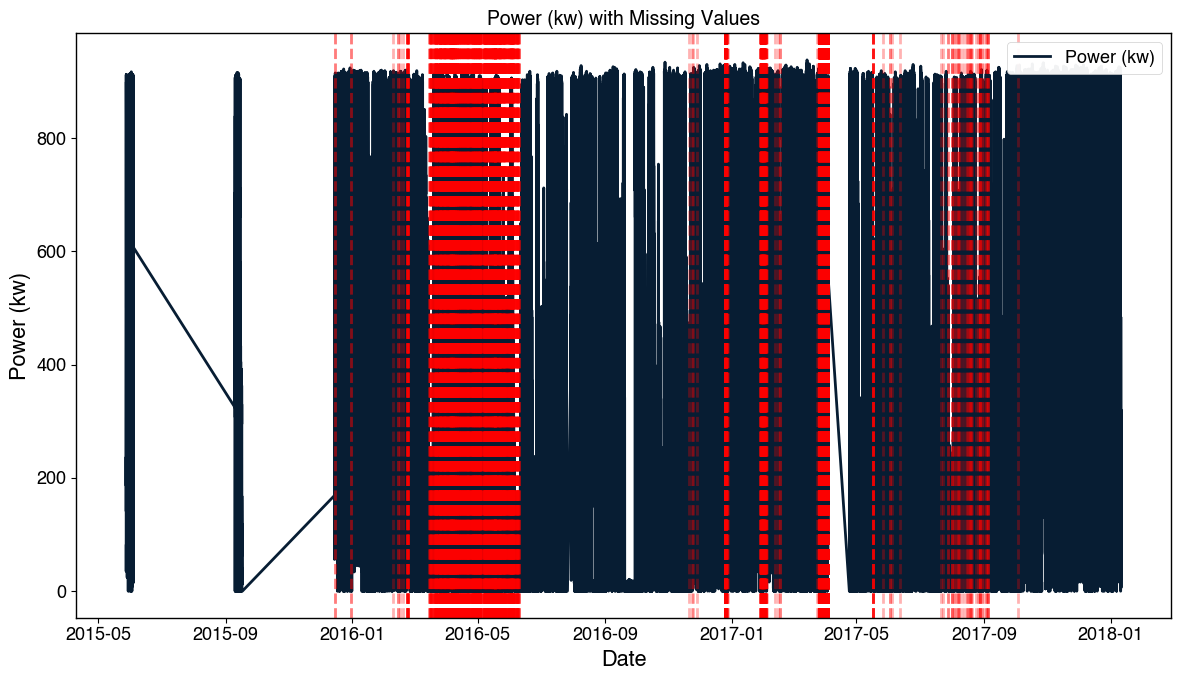

In [8]:
is_nan = ts_tt['Power_kw'].isna()

plt.figure(figsize=(12,7))
plt.plot(ts_tt.index, ts_tt['Power_kw'], label='Power (kw)')
for t in ts_tt.index[is_nan]:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.3)
plt.title('Power (kw) with Missing Values')
plt.xlabel('Date')
plt.ylabel('Power (kw)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In the plot above, the black line shows the recorded power output from the turbine over time. The red vertical lines highlight where the power values are explicitly marked as NaN (missing) in the dataset.

However, there’s a catch: not all missing data is shown in red! Some time periods don’t have any data at all — they're just completely missing from the dataset. These “silent gaps” don’t appear as NaNs because the rows for those timestamps aren’t even there. This is why we see long flat gaps in the black line, where the turbine output isn’t zero — the data is just missing entirely.

To properly handle these gaps, we’ll need to resample the data to a regular time interval (e.g., 1 minute) and then re-check for missing values. That way, both explicit NaNs and silent gaps are visible and can be treated.

## Data Sampling Interval

In [9]:
# Check Time Differences between each rows
ts_tt['delta'] = ts_tt.index.diff()
ts_tt_diff = pd.DataFrame(ts_tt['delta'].value_counts()).reset_index().sort_values('count', ascending=False)

print("Unique time differences:")
print(f'Unique time differences: {len(ts_tt_diff)}')


ts_tt_diff.head(5)

Unique time differences:
Unique time differences: 143


delta    count
0 0 days 00:01:00  1051543
1 0 days 00:00:59     6914
2 0 days 00:01:01     4305
3 0 days 00:00:01     2740
4 0 days 00:00:04     1124

Looking at the table, you can see that most of the data points (over a million!) were recorded every 60 seconds. But there are also many other intervals like 59 seconds, 61 seconds, 1 second, and even 4 seconds.

This shows that the data wasn't always recorded at regular intervals — it's a bit messy. That’s a problem because many time series methods assume data comes in at consistent intervals.

So this confirms that resampling the data (for example, forcing it to one reading every minute) is important before we do any further analysis. It helps clean things up and makes sure our models or visualizations work properly.

In [10]:
# Only rows where the time delta is not 1 minute
irregular_rows = ts_tt[ts_tt['delta'] != pd.Timedelta(minutes=1)]

ts_tt['prev_timestamp'] = ts_tt.index.to_series().shift()
ts_tt['prev_delta'] = ts_tt['delta'].shift()

# Re-extract irregular rows with context
irregular_context = ts_tt[ts_tt['delta'] != pd.Timedelta(minutes=1)][['prev_timestamp', 'delta']]
irregular_context['Timestamp'] = irregular_context.index
irregular_context = irregular_context[['prev_timestamp', 'Timestamp', 'delta']]

irregular_context = irregular_context.sort_values(by='delta', ascending=False).reset_index(drop=True)

display(irregular_context.head(10))


prev_timestamp           Timestamp            delta
0 2015-06-03 23:59:23 2015-09-10 00:00:30 98 days 00:01:07
1 2015-09-16 23:59:30 2015-12-14 21:03:10 88 days 21:03:40
2 2017-04-03 15:08:44 2017-04-24 03:20:06 20 days 12:11:22
3 2016-07-26 08:30:36 2016-07-29 21:38:56  3 days 13:08:20
4 2015-12-15 20:15:47 2015-12-17 13:47:31  1 days 17:31:44
5 2016-01-13 09:37:34 2016-01-14 09:20:34  0 days 23:43:00
6 2016-09-20 19:03:37 2016-09-21 14:21:37  0 days 19:18:00
7 2017-12-13 22:25:32 2017-12-14 05:31:32  0 days 07:06:00
8 2017-05-17 02:01:07 2017-05-17 08:38:50  0 days 06:37:43
9 2016-09-20 05:13:37 2016-09-20 11:49:37  0 days 06:36:00

In [11]:
ts_tt.head()

Power_kw  Setpoint_kw  Wind_ms           delta  \
Timestamp                                                             
2015-05-28 00:00:23      80.0        900.0      4.9             NaT   
2015-05-28 00:01:23      78.0        900.0      5.4 0 days 00:01:00   
2015-05-28 00:02:23      52.0        900.0      4.9 0 days 00:01:00   
2015-05-28 00:03:23      57.0        900.0      4.6 0 days 00:01:00   
2015-05-28 00:04:23      54.0        900.0      4.6 0 days 00:01:00   

                         prev_timestamp      prev_delta  
Timestamp                                                
2015-05-28 00:00:23                 NaT             NaT  
2015-05-28 00:01:23 2015-05-28 00:00:23             NaT  
2015-05-28 00:02:23 2015-05-28 00:01:23 0 days 00:01:00  
2015-05-28 00:03:23 2015-05-28 00:02:23 0 days 00:01:00  
2015-05-28 00:04:23 2015-05-28 00:03:23 0 days 00:01:00

## Resample and Check for Silent Gaps

In [12]:
# resample tt_ts to 1 minute intervals to show the actual missing values
ts_tt_res_1min = ts_tt.resample('1min').agg({
    'Power_kw': 'mean',
    'Setpoint_kw': 'mean',
    'Wind_ms': 'mean',
})

pd.DataFrame(ts_tt_res_1min.isna().sum()).rename(columns={0: 'Missing values'}).T

print(f"Total days of missing Power Data: {(ts_tt_res_1min['Power_kw'].isna().sum())/(60*24):.2f} days")
print(f"Total days of missing Setpoint Data: {(ts_tt_res_1min['Setpoint_kw'].isna().sum())/(60*24):.2f} days")
print(f"Total days of missing Wind Data: {(ts_tt_res_1min['Wind_ms'].isna().sum())/(60*24):.2f} days")

Total days of missing Power Data: 220.21 days
Total days of missing Setpoint Data: 220.22 days
Total days of missing Wind Data: 220.22 days


In [13]:
# Check Time Differences between each rows
ts_tt_res_1min['delta'] = ts_tt_res_1min.index.diff()
ts_tt_res_1min_diff = pd.DataFrame(ts_tt_res_1min['delta'].value_counts()).reset_index().sort_values('count', ascending=False)

print(f'Unique time differences: {len(ts_tt_res_1min_diff)}')


ts_tt_res_1min_diff.head(5)

Unique time differences: 1


delta    count
0 0 days 00:01:00  1381334

In [14]:
ts_tt_res_1min.head()

Power_kw  Setpoint_kw  Wind_ms           delta
Timestamp                                                          
2015-05-28 00:00:00      80.0        900.0      4.9             NaT
2015-05-28 00:01:00      78.0        900.0      5.4 0 days 00:01:00
2015-05-28 00:02:00      52.0        900.0      4.9 0 days 00:01:00
2015-05-28 00:03:00      57.0        900.0      4.6 0 days 00:01:00
2015-05-28 00:04:00      54.0        900.0      4.6 0 days 00:01:00

In [15]:
# # Calculate NaN streaks
# ts_tt_res_1min['NaN_streak'] = ts_tt_res_1min['Power_kw'].isna().astype(int).groupby(
#     ts_tt_res_1min['Power_kw'].isna().astype(int).cumsum()
# ).cumsum()

# # Filter only rows with NaN streaks
# nan_streaks = ts_tt_res_1min[ts_tt_res_1min['NaN_streak'] > 0].copy()

# # Compute cumulative count of non-NaN values
# notna_cumsum = ts_tt_res_1min['Power_kw'].notna().cumsum()

# # Assign the cumulative value to the nan_streaks DataFrame
# nan_streaks['Prev_non_NaN_index'] = notna_cumsum.iloc[::-1].iloc[::-1]
# nan_streaks['Prev_non_NaN_index'] = nan_streaks['Prev_non_NaN_index'].astype(int) - 1

# # Get index (timestamps) of all non-NaN values
# non_nan_indices = ts_tt_res_1min[ts_tt_res_1min['Power_kw'].notna()].index

# # Map each value to the corresponding timestamp or NaT if out of bounds
# nan_streaks['Prev_non_NaN_timestamp'] = nan_streaks['Prev_non_NaN_index'].map(
#     lambda x: non_nan_indices[x] if 0 <= x < len(non_nan_indices) else pd.NaT
# )

# nan_streaks.head()

## Deriving Power Curve

### Binning Method

### Weibull Distribution

To derive the power curve using the baseline wind speed and power output we will use a derivation of weibull distribution model to measure the distribution. 


$$
P(\nu) = P_r \left(1 - e^{- \left(\frac{\nu - v_0}{c}\right)^3} \right)
$$

Where:

* $\nu$ = wind speed
* $v_0$ = minimum wind speed (`v_min`)
* $c$ = scale parameter
* $P_r$ = rated power

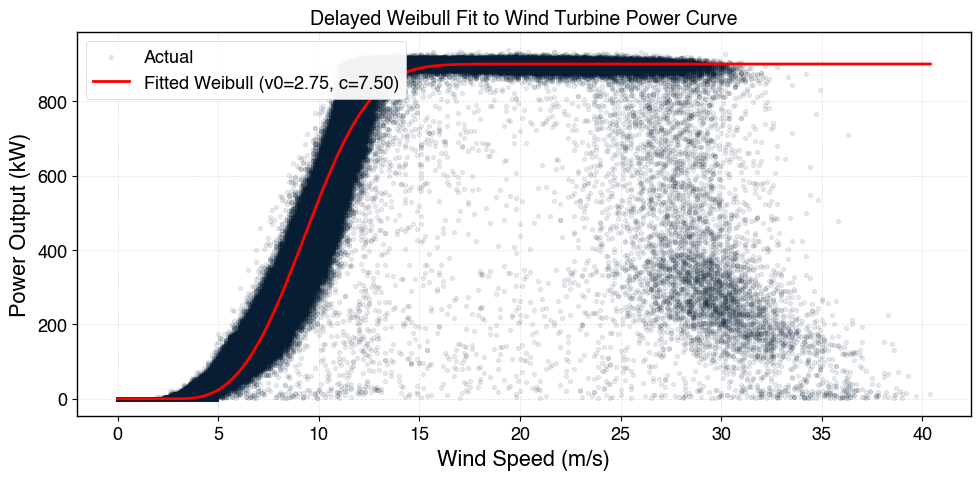

(np.float64(2.7517266628631627), np.float64(7.497871269620002))

In [16]:
def delayed_weibull(v:float, v0:float, c:float, pr:float):
    """
    Weibull model for wind speed distribution.
    
    Parameters:
    pr (float): Power rating of the turbine in kW. (or setpoint in our case i think)
    v (float): Wind speed in m/s.
    v0 (float): Scale parameter of the Weibull distribution in m/s.
    
    Returns:
    float: Power output in kW.
    """
    v = np.asarray(v)
    power = np.zeros_like(v)
    mask = v > v0
    power[mask] = pr * (1 - np.exp(-((v[mask] - v0) / c) ** 3))
    return power


df_model = df_tt_og.copy()

v_min = df_model[(df_model.loc[:, 'Power_kw'] >= 10.)].loc[:, 'Wind_ms'].quantile(0.1) # 10% quantile

df_model = df_model.query('Setpoint_kw == 900')

# remove data points when the wind speed is fast enough for power production but there is no power; turbine is probably manually switched off here
df_model.loc[((df_model.Wind_ms >= v_min) & (df_model.Power_kw.abs() <= 1e-5))] = np.nan

# remove all missing values from the dataframe
df_model = df_model.dropna(subset=['Power_kw', 'Wind_ms'])

# filter out above 895 wind speed

wind = df_model['Wind_ms'].values
power = df_model['Power_kw'].values

## Initial guesses for v0 and c
initial_guess = [2.7, 6.5]

## Fit curve
popt, pcov = curve_fit(lambda v, v0, c: delayed_weibull(v, v0, c, pr=900), wind, power, p0=initial_guess)

## Predicted values using fitted parameters
v0_fit, c_fit = popt
predicted_power = delayed_weibull(wind, v0_fit, c_fit, pr=900)

## Plot actual vs fitted curve
v_sorted = np.sort(wind)

predicted_sorted = delayed_weibull(v_sorted, v0_fit, c_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, label='Actual', s=10, alpha=0.1,)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Delayed Weibull Fit to Wind Turbine Power Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

v0_fit, c_fit

In [17]:

df_compare = pd.DataFrame({
    'Wind Speed (m/s)': wind,
    'Power Output (kW)': power,
    'Predicted Power Output (kW)': predicted_power
})

df_compare['Residuals'] = df_compare['Power Output (kW)'] - df_compare['Predicted Power Output (kW)']
df_compare['Residuals'] = df_compare['Residuals'].abs()

r_score = r2_score(df_compare['Power Output (kW)'], df_compare['Predicted Power Output (kW)'])
rmse = root_mean_squared_error(df_compare['Power Output (kW)'], df_compare['Predicted Power Output (kW)'])
mae = mean_absolute_error(df_compare['Power Output (kW)'], df_compare['Predicted Power Output (kW)'])
mse = mean_squared_error(df_compare['Power Output (kW)'], df_compare['Predicted Power Output (kW)'])

df_metrics = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE', 'MSE'],
    'Value': [r_score, rmse, mae, mse]
})

df_metrics.head()

Metric        Value
0    R^2     0.959718
1   RMSE    67.625342
2    MAE    39.009803
3    MSE  4573.186834

### Cut In & Cut Out Speed

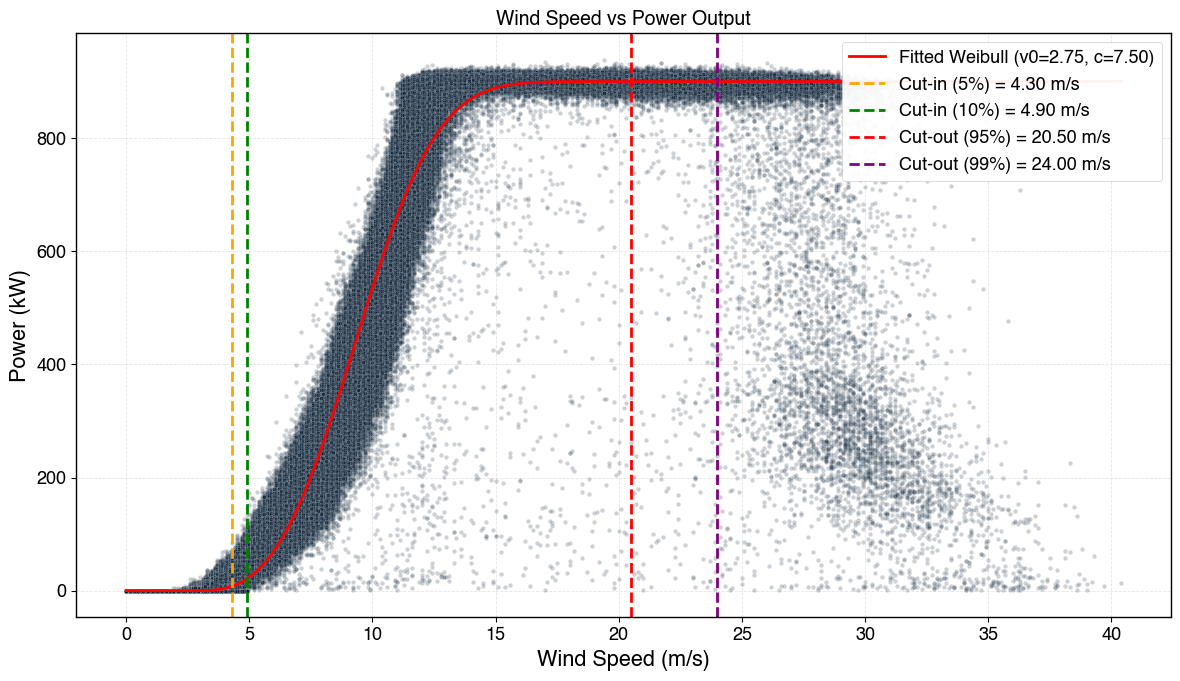

In [18]:
## Filter out rows with missing data
df_plot = df_model.dropna(subset=['Wind_ms', 'Power_kw'])

## Compute both quantiles for cut-in and cut-out
cutin_05 = df_plot[df_plot['Power_kw'] >= 10]['Wind_ms'].quantile(0.05)
cutin_10 = df_plot[df_plot['Power_kw'] >= 10]['Wind_ms'].quantile(0.10)
cutout_95 = df_plot[df_plot['Power_kw'] >= 10]['Wind_ms'].quantile(0.95)
cutout_99 = df_plot[df_plot['Power_kw'] >= 10]['Wind_ms'].quantile(0.98)

## Create scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_plot, x='Wind_ms', y='Power_kw', alpha=0.2, s=10)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')

## Draw cut-in / cut-out lines
plt.axvline(cutin_05, color='orange', linestyle='--', label=f'Cut-in (5%) = {cutin_05:.2f} m/s')
plt.axvline(cutin_10, color='green', linestyle='--', label=f'Cut-in (10%) = {cutin_10:.2f} m/s')
plt.axvline(cutout_95, color='red', linestyle='--', label=f'Cut-out (95%) = {cutout_95:.2f} m/s')
plt.axvline(cutout_99, color='purple', linestyle='--', label=f'Cut-out (99%) = {cutout_99:.2f} m/s')

## Labels and legend
plt.title('Wind Speed vs Power Output')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Resample to 30 Minutes

we are going to resample data to 30 minute interval to match our demand data

In [19]:
ts_tt_resampled = ts_tt.resample('30min').agg({
    'Power_kw': ['mean','count'],
    'Setpoint_kw': 'max',
    'Wind_ms': 'mean',
}).reset_index()

# flatten the columns
ts_tt_resampled.columns = ['_'.join(col).strip() if col[1] else col[0] for col in ts_tt_resampled.columns.values]

# Check Head
ts_tt_resampled.head()


Timestamp  Power_kw_mean  Power_kw_count  Setpoint_kw_max  \
0 2015-05-28 00:00:00          103.0              30            900.0   
1 2015-05-28 00:30:00          204.0              30            900.0   
2 2015-05-28 01:00:00          285.6              30            900.0   
3 2015-05-28 01:30:00          457.4              30            900.0   
4 2015-05-28 02:00:00          891.9              30            900.0   

   Wind_ms_mean  
0      5.533333  
1      7.040000  
2      7.876667  
3      9.166667  
4     12.973333

In [20]:
pd.DataFrame(ts_tt_resampled.isna().sum()).rename(columns={0: 'Missing values'}).T


Timestamp  Power_kw_mean  Power_kw_count  Setpoint_kw_max  \
Missing values          0          10372               0            10372   

                Wind_ms_mean  
Missing values         10372

## Treating Missing Values

### Scraped Data Cleaning

In [21]:
df_wd_og = load_data(RAW_DATASET_PATH/'kirkwall_weather.csv')
## Cleaning weather data
df_wd = df_wd_og.copy().rename(columns={'Time': 'Timestamp'})
## Convert timestamp to datetime
df_wd['Timestamp'] = pd.to_datetime(df_wd['Timestamp'])

## Sort value based on timestamp
df_wd = df_wd.sort_values('Timestamp').reset_index(drop=True)

## aligning timestamp 00:20 into 00:30 and 00:50 to 01:00
df_wd['Timestamp'] = df_wd.Timestamp.apply(lambda x: x + pd.Timedelta(minutes=10))

df_wd['Wind Speed (m/s)'] = pd.to_numeric(df_wd['Wind Speed (m/s)'], errors='coerce').fillna(0.0)

# Convert temperature Fahrenheit to Celsius and keep 1 decimal point
df_wd['Temperature (C)'] = (df_wd['Temperature (F)'] - 32) * 5.0 / 9.0

df_wd['Temperature (C)'] = df_wd['Temperature (C)'].round(1)
# Convert Non Numeric Values to NaN in Temperature
df_wd['Temperature (C)'] = pd.to_numeric(df_wd['Temperature (C)'], errors='coerce')

print(f"Weather scrape columns: {df_wd.columns}")
df_wd.head()

## df_wd.to_csv(PROCESSED_DATASET / 'kirkwall_weather_cleaned.csv', index=False)

## resample to 30 mminutes
df_wd_timeindex = df_wd.copy()
## Set the timestamp as index
## Convert 'Timestamp' column to datetime before setting index
df_wd_timeindex['Timestamp'] = pd.to_datetime(df_wd_timeindex['Timestamp'])

df_wd_timeindex = df_wd_timeindex.set_index('Timestamp')

##convert wind speed to numeric
df_wd_timeindex['Wind Speed (m/s)'] = pd.to_numeric(
    df_wd_timeindex['Wind Speed (m/s)'],
    errors='coerce'
).fillna(0) 

df_wd_timeindex = df_wd_timeindex[~df_wd_timeindex.index.duplicated(keep='first')]

# Select numeric columns and apply 30-minute resampling
df_wd_resampled = df_wd_timeindex.select_dtypes(include='number').resample('30min').mean()

# Reset index to make 'Timestamp' a column again
df_wd = df_wd_resampled.reset_index()

# Set index for further time series analysis
ts_wd = df_wd.set_index('Timestamp').copy()

Weather scrape columns: Index(['Timestamp', 'Icon', 'Temperature (F)', 'Description',
       'Wind Speed (m/s)', 'Wind Direction', 'Humidity (%)', 'Pressure (Hg)',
       'Visibility (mi)', 'Temperature (C)'],
      dtype='object')


In [22]:
ts_wd.head()

Temperature (F)  Wind Speed (m/s)  Humidity (%)  \
Timestamp                                                              
2017-01-01 00:30:00             41.0             10.28          81.0   
2017-01-01 01:00:00             43.0              9.39          81.0   
2017-01-01 01:30:00             41.0              9.83          87.0   
2017-01-01 02:00:00             39.0              7.15          87.0   
2017-01-01 02:30:00             41.0              8.94          76.0   

                     Pressure (Hg)  Visibility (mi)  Temperature (C)  
Timestamp                                                             
2017-01-01 00:30:00          30.04              NaN              5.0  
2017-01-01 01:00:00          30.04              NaN              6.1  
2017-01-01 01:30:00          30.04              NaN              5.0  
2017-01-01 02:00:00          30.07              5.0              3.9  
2017-01-01 02:30:00          30.07              NaN              5.0

## Combined Scrape and Turbine Data

In [23]:
ts_combined = ts_tt_resampled.merge(
    ts_wd[['Wind Speed (m/s)', 'Temperature (C)']],
    left_on='Timestamp',
    right_on='Timestamp',
    how='left'
)

ts_combined['Timestamp'] = pd.to_datetime(ts_combined['Timestamp'])

ts_combined = ts_combined.set_index('Timestamp')

## Filter 2017-01-01 to 2018-01-01
ts_combined = ts_combined.loc['2017-01-01':'2018-01-01']

ts_combined.head()

Power_kw_mean  Power_kw_count  Setpoint_kw_max  \
Timestamp                                                             
2017-01-01 00:00:00     894.033333              30            900.0   
2017-01-01 00:30:00     898.266667              30            900.0   
2017-01-01 01:00:00     902.866667              30            900.0   
2017-01-01 01:30:00     907.833333              30            900.0   
2017-01-01 02:00:00     907.000000               1            900.0   

                     Wind_ms_mean  Wind Speed (m/s)  Temperature (C)  
Timestamp                                                             
2017-01-01 00:00:00     13.820000               NaN              NaN  
2017-01-01 00:30:00     16.106667             10.28              5.0  
2017-01-01 01:00:00     16.380000              9.39              6.1  
2017-01-01 01:30:00     17.083333              9.83              5.0  
2017-01-01 02:00:00     16.800000              7.15              3.9

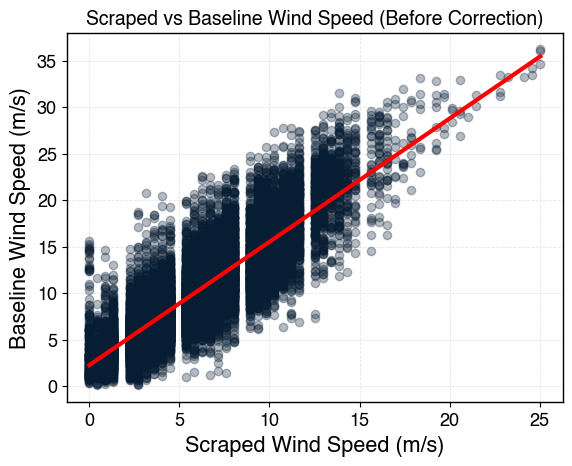

In [24]:
sns.regplot(
    data=ts_combined,
    x='Wind Speed (m/s)',
    y='Wind_ms_mean',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'},
)

plt.xlabel('Scraped Wind Speed (m/s)')
plt.ylabel('Baseline Wind Speed (m/s)')
plt.title('Scraped vs Baseline Wind Speed (Before Correction)')
plt.grid(True)
plt.show()


In [25]:
# Correlation between the two wind speed measurements
correlation = ts_combined['Wind Speed (m/s)'].corr(ts_combined['Wind_ms_mean'])
print(f"Correlation between scraped and baseline wind speed: {correlation:.2f}")

Correlation between scraped and baseline wind speed: 0.84


Since the scraped wind data consistently shows lower values over time compared to the baseline, this could be due to differences in measurement location, such as being recorded at a lower altitude or from a slightly different area in Orkney. Additionally, because the relationship between scraped and baseline wind speeds appears to be fairly linear and the correlation is quite high, we can justify applying a linear regression model to correct the scraped data.

In [26]:
## Drop rows with missing values for training
df_clean = ts_combined.dropna(subset=['Wind Speed (m/s)', 'Wind_ms_mean'])

## Fit linear regression
X = df_clean[['Wind Speed (m/s)']]
y = df_clean['Wind_ms_mean'].values

model = LinearRegression()
model.fit(X, y)

## Apply model to full dataset (including rows with NaNs in baseline)
ts_combined['Scrape_linear_scaled_wind_ms'] = np.nan  ## initialize with NaNs
mask = ts_combined['Wind Speed (m/s)'].notna()
ts_combined.loc[mask, 'Scrape_linear_scaled_wind_ms'] = model.predict(ts_combined.loc[mask, ['Wind Speed (m/s)']])

y_pred = model.predict(X)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = root_mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Linear Regression Correction:")
print(f"MAE: {mae:.2f} m/s")
print(f"MSE: {mse:.2f} m²/s²")
print(f"RMSE: {rmse:.2f} m/s")
print(f"R² Score: {r2:.2f}")

print('')

baseline_mask = ts_combined['Wind_ms_mean'].notna() & ts_combined['Wind Speed (m/s)'].notna()

print(f'Baseline Error Metrics:')
print(f"MAE: {mean_absolute_error(ts_combined.loc[baseline_mask, 'Wind_ms_mean'], ts_combined.loc[baseline_mask, 'Wind Speed (m/s)']):.2f} m/s")
print(f"MSE: {mean_squared_error(ts_combined.loc[baseline_mask, 'Wind_ms_mean'], ts_combined.loc[baseline_mask, 'Wind Speed (m/s)']):.2f} m²/s²")
print(f"RMSE: {root_mean_squared_error(ts_combined.loc[baseline_mask, 'Wind_ms_mean'], ts_combined.loc[baseline_mask, 'Wind Speed (m/s)']):.2f} m/s")
print(f"R² Score: {r2_score(ts_combined.loc[baseline_mask, 'Wind_ms_mean'], ts_combined.loc[baseline_mask, 'Wind Speed (m/s)']):.2f}")

ts_combined.head()

Linear Regression Correction:
MAE: 2.26 m/s
MSE: 8.55 m²/s²
RMSE: 2.92 m/s
R² Score: 0.71

Baseline Error Metrics:
MAE: 4.33 m/s
MSE: 27.85 m²/s²
RMSE: 5.28 m/s
R² Score: 0.05


Power_kw_mean  Power_kw_count  Setpoint_kw_max  \
Timestamp                                                             
2017-01-01 00:00:00     894.033333              30            900.0   
2017-01-01 00:30:00     898.266667              30            900.0   
2017-01-01 01:00:00     902.866667              30            900.0   
2017-01-01 01:30:00     907.833333              30            900.0   
2017-01-01 02:00:00     907.000000               1            900.0   

                     Wind_ms_mean  Wind Speed (m/s)  Temperature (C)  \
Timestamp                                                              
2017-01-01 00:00:00     13.820000               NaN              NaN   
2017-01-01 00:30:00     16.106667             10.28              5.0   
2017-01-01 01:00:00     16.380000              9.39              6.1   
2017-01-01 01:30:00     17.083333              9.83              5.0   
2017-01-01 02:00:00     16.800000              7.15              3.9   

                     Scrape_linear_scaled_wind_ms  
Timestamp                                          
2017-01-01 00:00:00                           NaN  
2017-01-01 00:30:00                     15.885371  
2017-01-01 01:00:00                     14.705182  
2017-01-01 01:30:00                     15.288646  
2017-01-01 02:00:00                     11.734821

The R² score increased from 0.05 to 0.71, which means the linear regression model explains 71% of the variance in the corrected wind speed values. The RMSE also dropped significantly, from 5.26 m/s to 2.92 m/s, indicating that the model provides much more accurate predictions.

We use linear regression in this case because it’s a simple and effective method for correcting systematic bias or scaling issues in sensor data. By fitting a straight line between the predicted and actual values, we can adjust the raw measurements to better reflect reality. This approach is especially useful when the relationship between the two variables is approximately linear, as it appears to be in this case.

---

## Data Cleaning & Filling Logic for Wind Power Dataset

### 1. **Filling Missing Wind Speed**

* **Primary source:** `Baseline_wind_ms`
* **Backup source:** `Scrape_linear_scaled_wind_ms`


- If Baseline_wind_ms is not missing:
    - Wind_ms = Baseline_wind_ms
    - Wind_data_source = "baseline"
- Else:
    - Wind_ms = Scrape_linear_scaled_wind_ms
    - Wind_data_source = "scraped"


A new column `Wind_data_source` is created to indicate the origin of the filled value (`"baseline"` or `"scraped"`).


In [27]:
missing_wind_mask = ts_combined['Wind_ms_mean'].isna()

ts_combined[missing_wind_mask].tail(10)

ts_combined['Final_wind_ms'] = ts_combined['Wind_ms_mean']
mask = ts_combined['Wind_ms_mean'].isna()

## Fill missing with corrected scraped wind
ts_combined.loc[mask, 'Final_wind_ms'] = ts_combined.loc[mask, 'Scrape_linear_scaled_wind_ms']

## Track data source
ts_combined['Wind_data_source'] = 'baseline'
ts_combined.loc[mask, 'Wind_data_source'] = 'scraped'


ts_combined.head()


Power_kw_mean  Power_kw_count  Setpoint_kw_max  \
Timestamp                                                             
2017-01-01 00:00:00     894.033333              30            900.0   
2017-01-01 00:30:00     898.266667              30            900.0   
2017-01-01 01:00:00     902.866667              30            900.0   
2017-01-01 01:30:00     907.833333              30            900.0   
2017-01-01 02:00:00     907.000000               1            900.0   

                     Wind_ms_mean  Wind Speed (m/s)  Temperature (C)  \
Timestamp                                                              
2017-01-01 00:00:00     13.820000               NaN              NaN   
2017-01-01 00:30:00     16.106667             10.28              5.0   
2017-01-01 01:00:00     16.380000              9.39              6.1   
2017-01-01 01:30:00     17.083333              9.83              5.0   
2017-01-01 02:00:00     16.800000              7.15              3.9   

                     Scrape_linear_scaled_wind_ms  Final_wind_ms  \
Timestamp                                                          
2017-01-01 00:00:00                           NaN      13.820000   
2017-01-01 00:30:00                     15.885371      16.106667   
2017-01-01 01:00:00                     14.705182      16.380000   
2017-01-01 01:30:00                     15.288646      17.083333   
2017-01-01 02:00:00                     11.734821      16.800000   

                    Wind_data_source  
Timestamp                             
2017-01-01 00:00:00         baseline  
2017-01-01 00:30:00         baseline  
2017-01-01 01:00:00         baseline  
2017-01-01 01:30:00         baseline  
2017-01-01 02:00:00         baseline


### 2. **Filling Missing Power Values**

We address cases where the baseline power data is missing (`NaN`) and estimate it based on wind speed using a *delayed Weibull* function **only when appropriate**.

#### Rules:

* If wind speed is **missing**, we **know the data is missing**, so we assume it’s safe to estimate and calculate power using the delayed Weibull function.
* If wind speed is **below** `v_min`, power is naturally expected to be zero → we calculate it using the Weibull function (though it will return near-zero).
* If wind speed is **above** `v_min` and power is `NaN`, this might indicate it is purposely turned off (i.e. the turbine was in maintenance) → we **don't** calculate and leave it as `NaN`.

$$
P(\nu) = P_r \left(1 - e^{- \left(\frac{\nu - v_0}{c}\right)^3} \right)
$$

Where:

* $\nu$ = wind speed
* $v_0$ = minimum wind speed (`v_min`)
* $c$ = scale parameter
* $P_r$ = rated power


- If Power_baseline is not missing:
    - Power = Power_baseline
    - Power_data_source = "baseline"

- Else:
    - If Wind_ms is missing OR Wind_ms < v_min:
        - Power = Plugging wind data to delayed Weibull function:
        - Power_data_source = "scraped"
    - Else:
        - Power = NaN  ## Wind is sufficient, but power is missing → likely curtailment
        - Power_data_source = "scraped"


A new column `Power_data_source` is created to indicate whether power was from:

* `"baseline"` → original data
* `"scraped"` → calculated using the Weibull function


In [28]:
# Calculate power output using the Weibull model
ts_combined['Predicted_power_kw'] = delayed_weibull(ts_combined['Final_wind_ms'], v0_fit, c_fit, pr=900)


# Turbine_power_kw initialize with baseline power
ts_combined['Turbine_power_kw'] = ts_combined['Power_kw_mean']

# Define where it's safe to fill: no curtailment or shut-down
fill_mask = ts_combined['Power_kw_mean'].isna() & (
    ts_combined['Wind_ms_mean'].isna()   ## can't assess → OK to fill
    # | (ts_combined['Baseline_wind_ms'] < _v_cut_in)   ## not enough wind
    # | (ts_combined['Baseline_wind_ms'] > _v_cut_out)    ## above cut-out (optional: derating)
)

# Fill with predicted power where appropriate
ts_combined.loc[fill_mask, 'Turbine_power_kw'] = ts_combined.loc[fill_mask, 'Predicted_power_kw']

# Add power data source flag
ts_combined['Power_data_source'] = 'baseline'
ts_combined.loc[fill_mask, 'Power_data_source'] = 'predicted'

ts_combined.loc[
    ts_combined['Power_kw_mean'].isna() &
    (ts_combined['Wind_ms_mean'] > v_min),
    'Power_data_source'
] = 'not_operating'

ts_combined.loc[
    ts_combined['Wind_ms_mean'].isna() &
    ts_combined['Wind Speed (m/s)'].isna(),
    'Power_data_source'
] = 'not_available'

## when Power data source is not_available set the power to NaN
ts_combined.loc[
    ts_combined['Power_data_source'] == 'not_available',
    'Turbine_power_kw'
] = np.nan

# power data source is baseline check the respecting wind data source and if it is above 25 set the power to 0
ts_combined.loc[
    ts_combined['Final_wind_ms'] > 25,
    'Turbine_power_kw'
] = 0


In [29]:
ts_combined[ts_combined.Power_data_source == 'not_available'].head()

Power_kw_mean  Power_kw_count  Setpoint_kw_max  \
Timestamp                                                             
2017-04-03 21:30:00            NaN               0              NaN   
2017-04-04 03:00:00            NaN               0              NaN   
2017-04-04 13:30:00            NaN               0              NaN   
2017-04-04 14:30:00            NaN               0              NaN   
2017-04-04 18:30:00            NaN               0              NaN   

                     Wind_ms_mean  Wind Speed (m/s)  Temperature (C)  \
Timestamp                                                              
2017-04-03 21:30:00           NaN               NaN              NaN   
2017-04-04 03:00:00           NaN               NaN              NaN   
2017-04-04 13:30:00           NaN               NaN              NaN   
2017-04-04 14:30:00           NaN               NaN              NaN   
2017-04-04 18:30:00           NaN               NaN              NaN   

                     Scrape_linear_scaled_wind_ms  Final_wind_ms  \
Timestamp                                                          
2017-04-03 21:30:00                           NaN            NaN   
2017-04-04 03:00:00                           NaN            NaN   
2017-04-04 13:30:00                           NaN            NaN   
2017-04-04 14:30:00                           NaN            NaN   
2017-04-04 18:30:00                           NaN            NaN   

                    Wind_data_source  Predicted_power_kw  Turbine_power_kw  \
Timestamp                                                                    
2017-04-03 21:30:00          scraped                 0.0               NaN   
2017-04-04 03:00:00          scraped                 0.0               NaN   
2017-04-04 13:30:00          scraped                 0.0               NaN   
2017-04-04 14:30:00          scraped                 0.0               NaN   
2017-04-04 18:30:00          scraped                 0.0               NaN   

                    Power_data_source  
Timestamp                              
2017-04-03 21:30:00     not_available  
2017-04-04 03:00:00     not_available  
2017-04-04 13:30:00     not_available  
2017-04-04 14:30:00     not_available  
2017-04-04 18:30:00     not_available

## Power to Energy

$$
\boxed{\text{Energy (kWh)} = \text{Power (kW)} \times \text{Time (hours)}}
$$

We are going to convert the power measured in Kilowatt to energy (kilowatt per hour). However, since our data is in 30 minute interval we are going to multiply our power by 0.5

In [30]:
ts_combined['Turbine_energy_kwh'] = ts_combined['Turbine_power_kw'] * 0.5 ## cause our data is 30 min

ts_combined.head()

Power_kw_mean  Power_kw_count  Setpoint_kw_max  \
Timestamp                                                             
2017-01-01 00:00:00     894.033333              30            900.0   
2017-01-01 00:30:00     898.266667              30            900.0   
2017-01-01 01:00:00     902.866667              30            900.0   
2017-01-01 01:30:00     907.833333              30            900.0   
2017-01-01 02:00:00     907.000000               1            900.0   

                     Wind_ms_mean  Wind Speed (m/s)  Temperature (C)  \
Timestamp                                                              
2017-01-01 00:00:00     13.820000               NaN              NaN   
2017-01-01 00:30:00     16.106667             10.28              5.0   
2017-01-01 01:00:00     16.380000              9.39              6.1   
2017-01-01 01:30:00     17.083333              9.83              5.0   
2017-01-01 02:00:00     16.800000              7.15              3.9   

                     Scrape_linear_scaled_wind_ms  Final_wind_ms  \
Timestamp                                                          
2017-01-01 00:00:00                           NaN      13.820000   
2017-01-01 00:30:00                     15.885371      16.106667   
2017-01-01 01:00:00                     14.705182      16.380000   
2017-01-01 01:30:00                     15.288646      17.083333   
2017-01-01 02:00:00                     11.734821      16.800000   

                    Wind_data_source  Predicted_power_kw  Turbine_power_kw  \
Timestamp                                                                    
2017-01-01 00:00:00         baseline          863.925628        894.033333   
2017-01-01 00:30:00         baseline          896.836847        898.266667   
2017-01-01 01:00:00         baseline          897.780113        902.866667   
2017-01-01 01:30:00         baseline          899.165620        907.833333   
2017-01-01 02:00:00         baseline          898.747696        907.000000   

                    Power_data_source  Turbine_energy_kwh  
Timestamp                                                  
2017-01-01 00:00:00          baseline          447.016667  
2017-01-01 00:30:00          baseline          449.133333  
2017-01-01 01:00:00          baseline          451.433333  
2017-01-01 01:30:00          baseline          453.916667  
2017-01-01 02:00:00          baseline          453.500000

In [31]:
## check final NaN values
print(f'Final NaN values in Final_wind_ms: {ts_combined["Final_wind_ms"].isna().sum()}')
print(f'Final NaN values in Turbine_power_kw: {ts_combined["Turbine_power_kw"].isna().sum()}')


Final NaN values in Final_wind_ms: 65
Final NaN values in Turbine_power_kw: 65


In [32]:
## check the missing final_wind_ms
ts_combined[ts_combined['Final_wind_ms'].isna()].head(5)

Power_kw_mean  Power_kw_count  Setpoint_kw_max  \
Timestamp                                                             
2017-04-03 21:30:00            NaN               0              NaN   
2017-04-04 03:00:00            NaN               0              NaN   
2017-04-04 13:30:00            NaN               0              NaN   
2017-04-04 14:30:00            NaN               0              NaN   
2017-04-04 18:30:00            NaN               0              NaN   

                     Wind_ms_mean  Wind Speed (m/s)  Temperature (C)  \
Timestamp                                                              
2017-04-03 21:30:00           NaN               NaN              NaN   
2017-04-04 03:00:00           NaN               NaN              NaN   
2017-04-04 13:30:00           NaN               NaN              NaN   
2017-04-04 14:30:00           NaN               NaN              NaN   
2017-04-04 18:30:00           NaN               NaN              NaN   

                     Scrape_linear_scaled_wind_ms  Final_wind_ms  \
Timestamp                                                          
2017-04-03 21:30:00                           NaN            NaN   
2017-04-04 03:00:00                           NaN            NaN   
2017-04-04 13:30:00                           NaN            NaN   
2017-04-04 14:30:00                           NaN            NaN   
2017-04-04 18:30:00                           NaN            NaN   

                    Wind_data_source  Predicted_power_kw  Turbine_power_kw  \
Timestamp                                                                    
2017-04-03 21:30:00          scraped                 0.0               NaN   
2017-04-04 03:00:00          scraped                 0.0               NaN   
2017-04-04 13:30:00          scraped                 0.0               NaN   
2017-04-04 14:30:00          scraped                 0.0               NaN   
2017-04-04 18:30:00          scraped                 0.0               NaN   

                    Power_data_source  Turbine_energy_kwh  
Timestamp                                                  
2017-04-03 21:30:00     not_available                 NaN  
2017-04-04 03:00:00     not_available                 NaN  
2017-04-04 13:30:00     not_available                 NaN  
2017-04-04 14:30:00     not_available                 NaN  
2017-04-04 18:30:00     not_available                 NaN

## Drop The Final Missing Value

In [33]:
## drop the row with missing values of Turbine_energy_kwh
ts_dropped = ts_combined.dropna(subset=['Turbine_energy_kwh'])

ts_dropped.isna().sum()


Power_kw_mean                   947
Power_kw_count                    0
Setpoint_kw_max                 947
Wind_ms_mean                    947
Wind Speed (m/s)                922
Temperature (C)                 922
Scrape_linear_scaled_wind_ms    922
Final_wind_ms                     0
Wind_data_source                  0
Predicted_power_kw                0
Turbine_power_kw                  0
Power_data_source                 0
Turbine_energy_kwh                0
dtype: int64

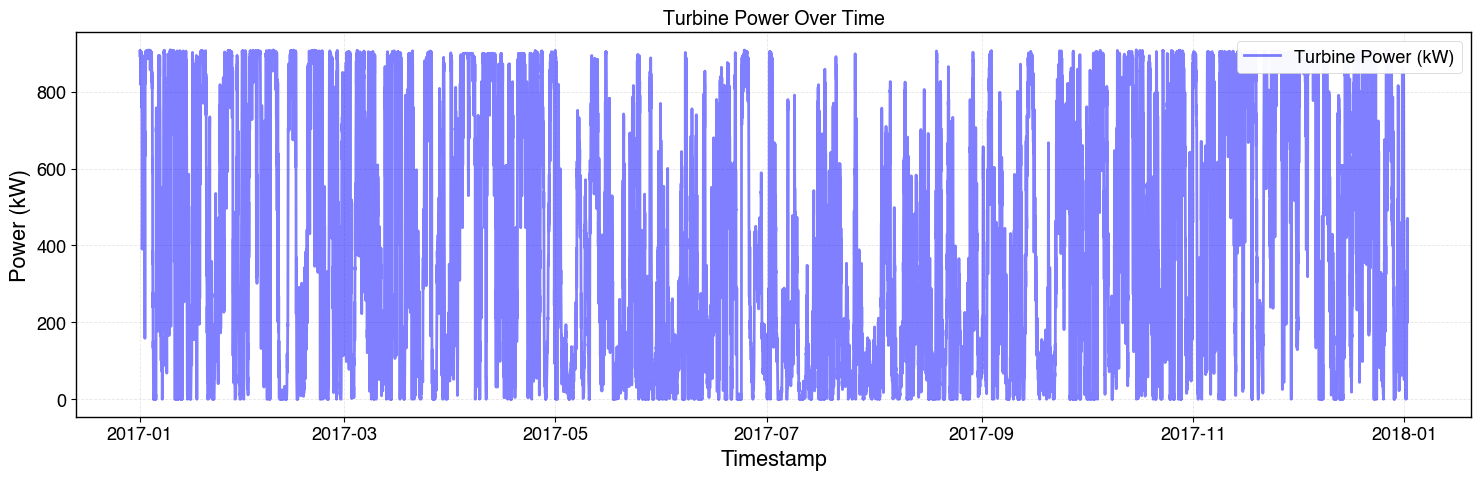

In [34]:
## plot the turbine power of the time series
plt.figure(figsize=(15, 5))
plt.plot(ts_dropped.index, ts_dropped['Turbine_power_kw'], label='Turbine Power (kW)', color='blue', alpha=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Power (kW)')
plt.title('Turbine Power Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Demand Data

In [35]:
def load_data(filename):
    return pd.read_csv(RAW_DATASET_PATH / filename)

df_rd = load_data('Residential_demand.csv')

df_rd['Timestamp'] = pd.to_datetime(df_rd['Timestamp'])

print(f"residential demand shape: {df_rd.shape}")
df_rd.head()


residential demand shape: (17568, 3)


Timestamp  Demand_mean_kw  N_households
0 2017-01-01 00:00:00        0.220106          5428
1 2017-01-01 00:30:00        0.205945          5429
2 2017-01-01 01:00:00        0.189090          5429
3 2017-01-01 01:30:00        0.173118          5429
4 2017-01-01 02:00:00        0.159051          5429

In [36]:
df_rd['Month_int'] = df_rd['Timestamp'].dt.month
df_rd['Date'] = df_rd['Timestamp'].dt.date
ts_rd = df_rd.set_index('Timestamp').copy()

ts_rd.head()

Demand_mean_kw  N_households  Month_int        Date
Timestamp                                                               
2017-01-01 00:00:00        0.220106          5428          1  2017-01-01
2017-01-01 00:30:00        0.205945          5429          1  2017-01-01
2017-01-01 01:00:00        0.189090          5429          1  2017-01-01
2017-01-01 01:30:00        0.173118          5429          1  2017-01-01
2017-01-01 02:00:00        0.159051          5429          1  2017-01-01

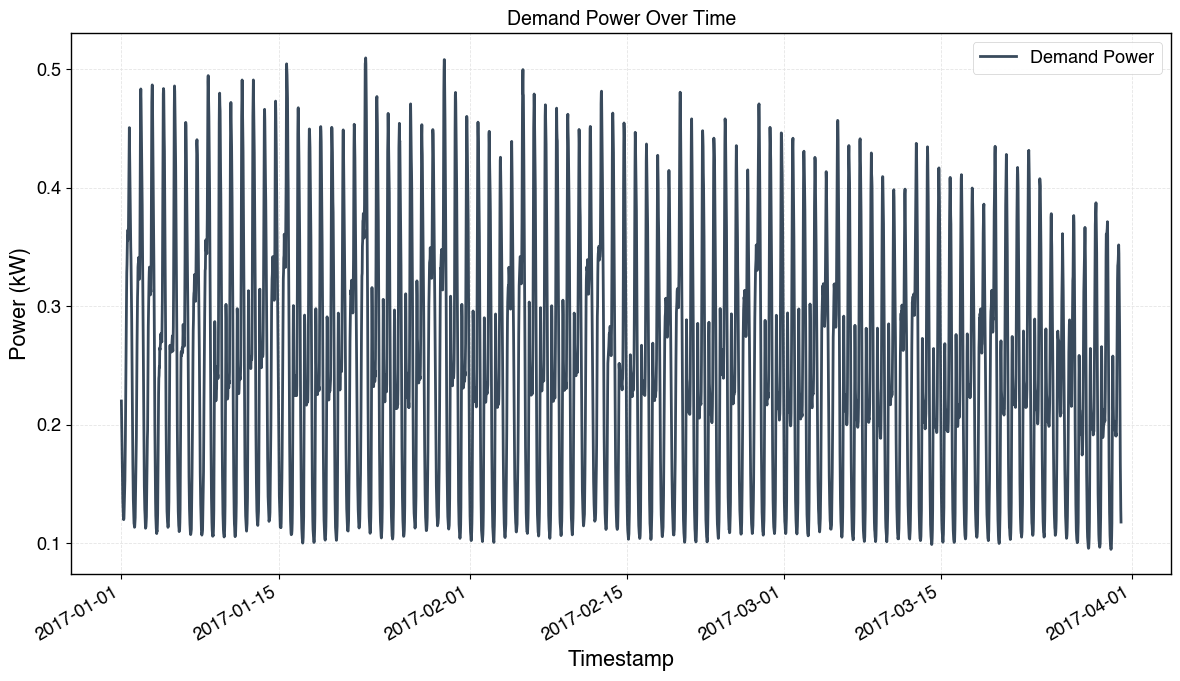

In [37]:
ts_rd_zoom = ts_rd[(ts_rd.index >= '2017-01-01') & (ts_rd.index <= '2017-03-31')]

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(ts_rd_zoom.index, ts_rd_zoom['Demand_mean_kw'], label='Demand Power', alpha=0.8)
ax.set_title('Demand Power Over Time')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Power (kW)')
ax.legend()
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

We could see some oscillation in the data that align with real life observation where there could be peak and off-peak usage of power. There is also a trend of power usage decreasing from January to April where weather might be warmer in april. We can confirm our hunches through time series decomposition

## Time Series Analysis

### Decomposition

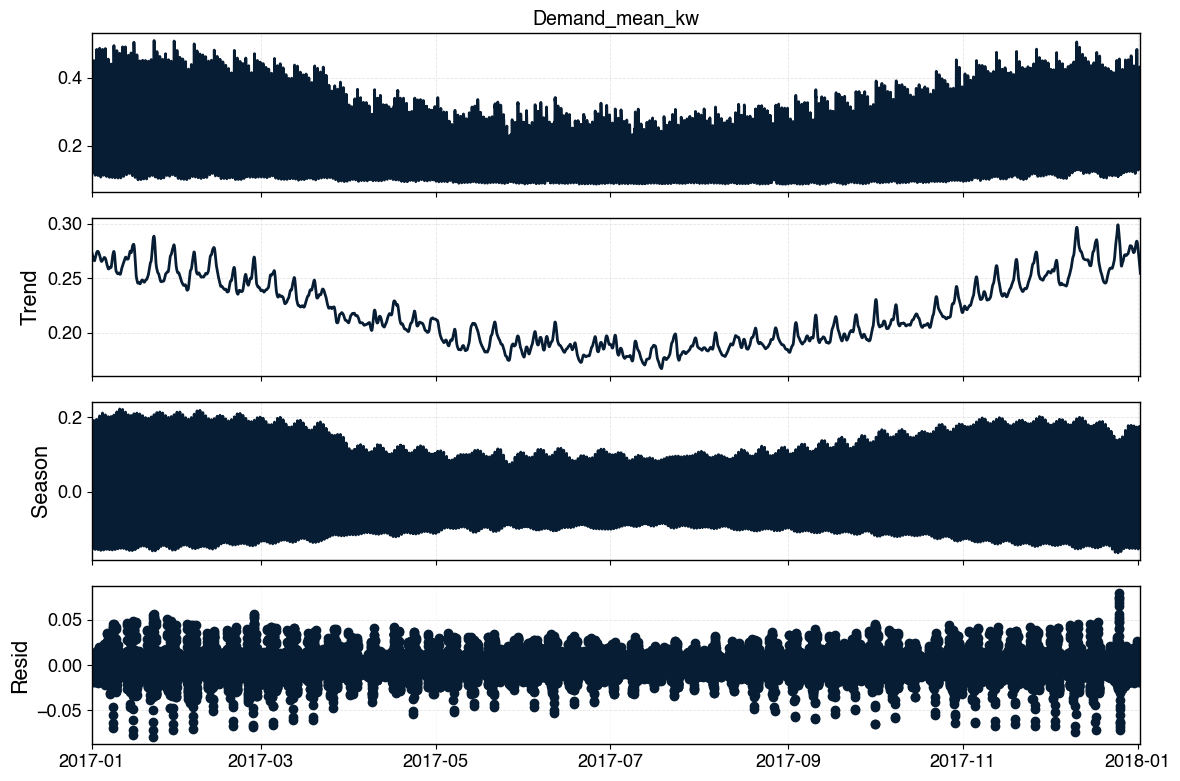

In [38]:
from statsmodels.tsa.seasonal import STL


stl = STL(ts_rd['Demand_mean_kw'], period=48)  # data is in 30-minute intervals, so period=48 for daily seasonality
res = stl.fit()

# Plot with custom size and layout
fig = res.plot()
fig.set_size_inches(12, 8)  # width, height in inches
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.show()


Since the data is from Orkney, Scotland, the pattern starts to make a lot more sense. Orkney has a cool and often windy climate, with long daylight hours in the summer and short, dark days in the winter. A lot of homes rely on electricity for heating and lighting, especially in rural areas where other energy options might be limited.

The increase demand around September probably marks the start of colder weather. People begin using electric heaters, lights, and maybe cooking indoors more often as the days get shorter.

The daily pattern also becomes more extreme later in the year. That’s likely because people use more electricity in the mornings and evenings when it's darker and colder outside. So the bigger daily swings in the seasonal component match what you’d expect for Orkney’s winter life—lights on earlier, heaters running longer, and more indoor activity overall.

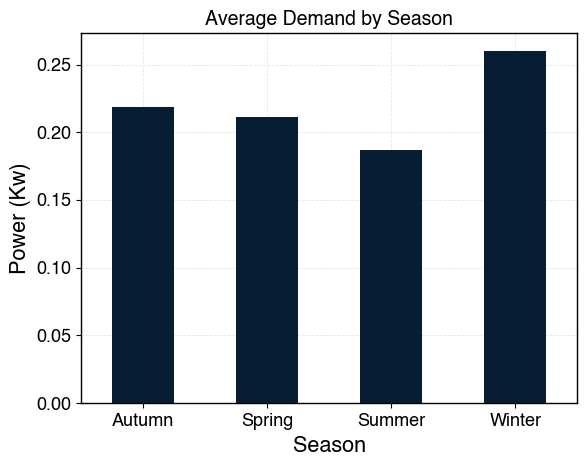

In [39]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

ts_rd['Season'] = ts_rd['Month_int'].apply(get_season)

ts_rd.groupby('Season')['Demand_mean_kw'].mean().plot(kind='bar', title='Average Demand by Season')
plt.ylabel('Power (Kw)')
#rotate x-axis labels for better readability
plt.xticks(rotation=0)
plt.show()

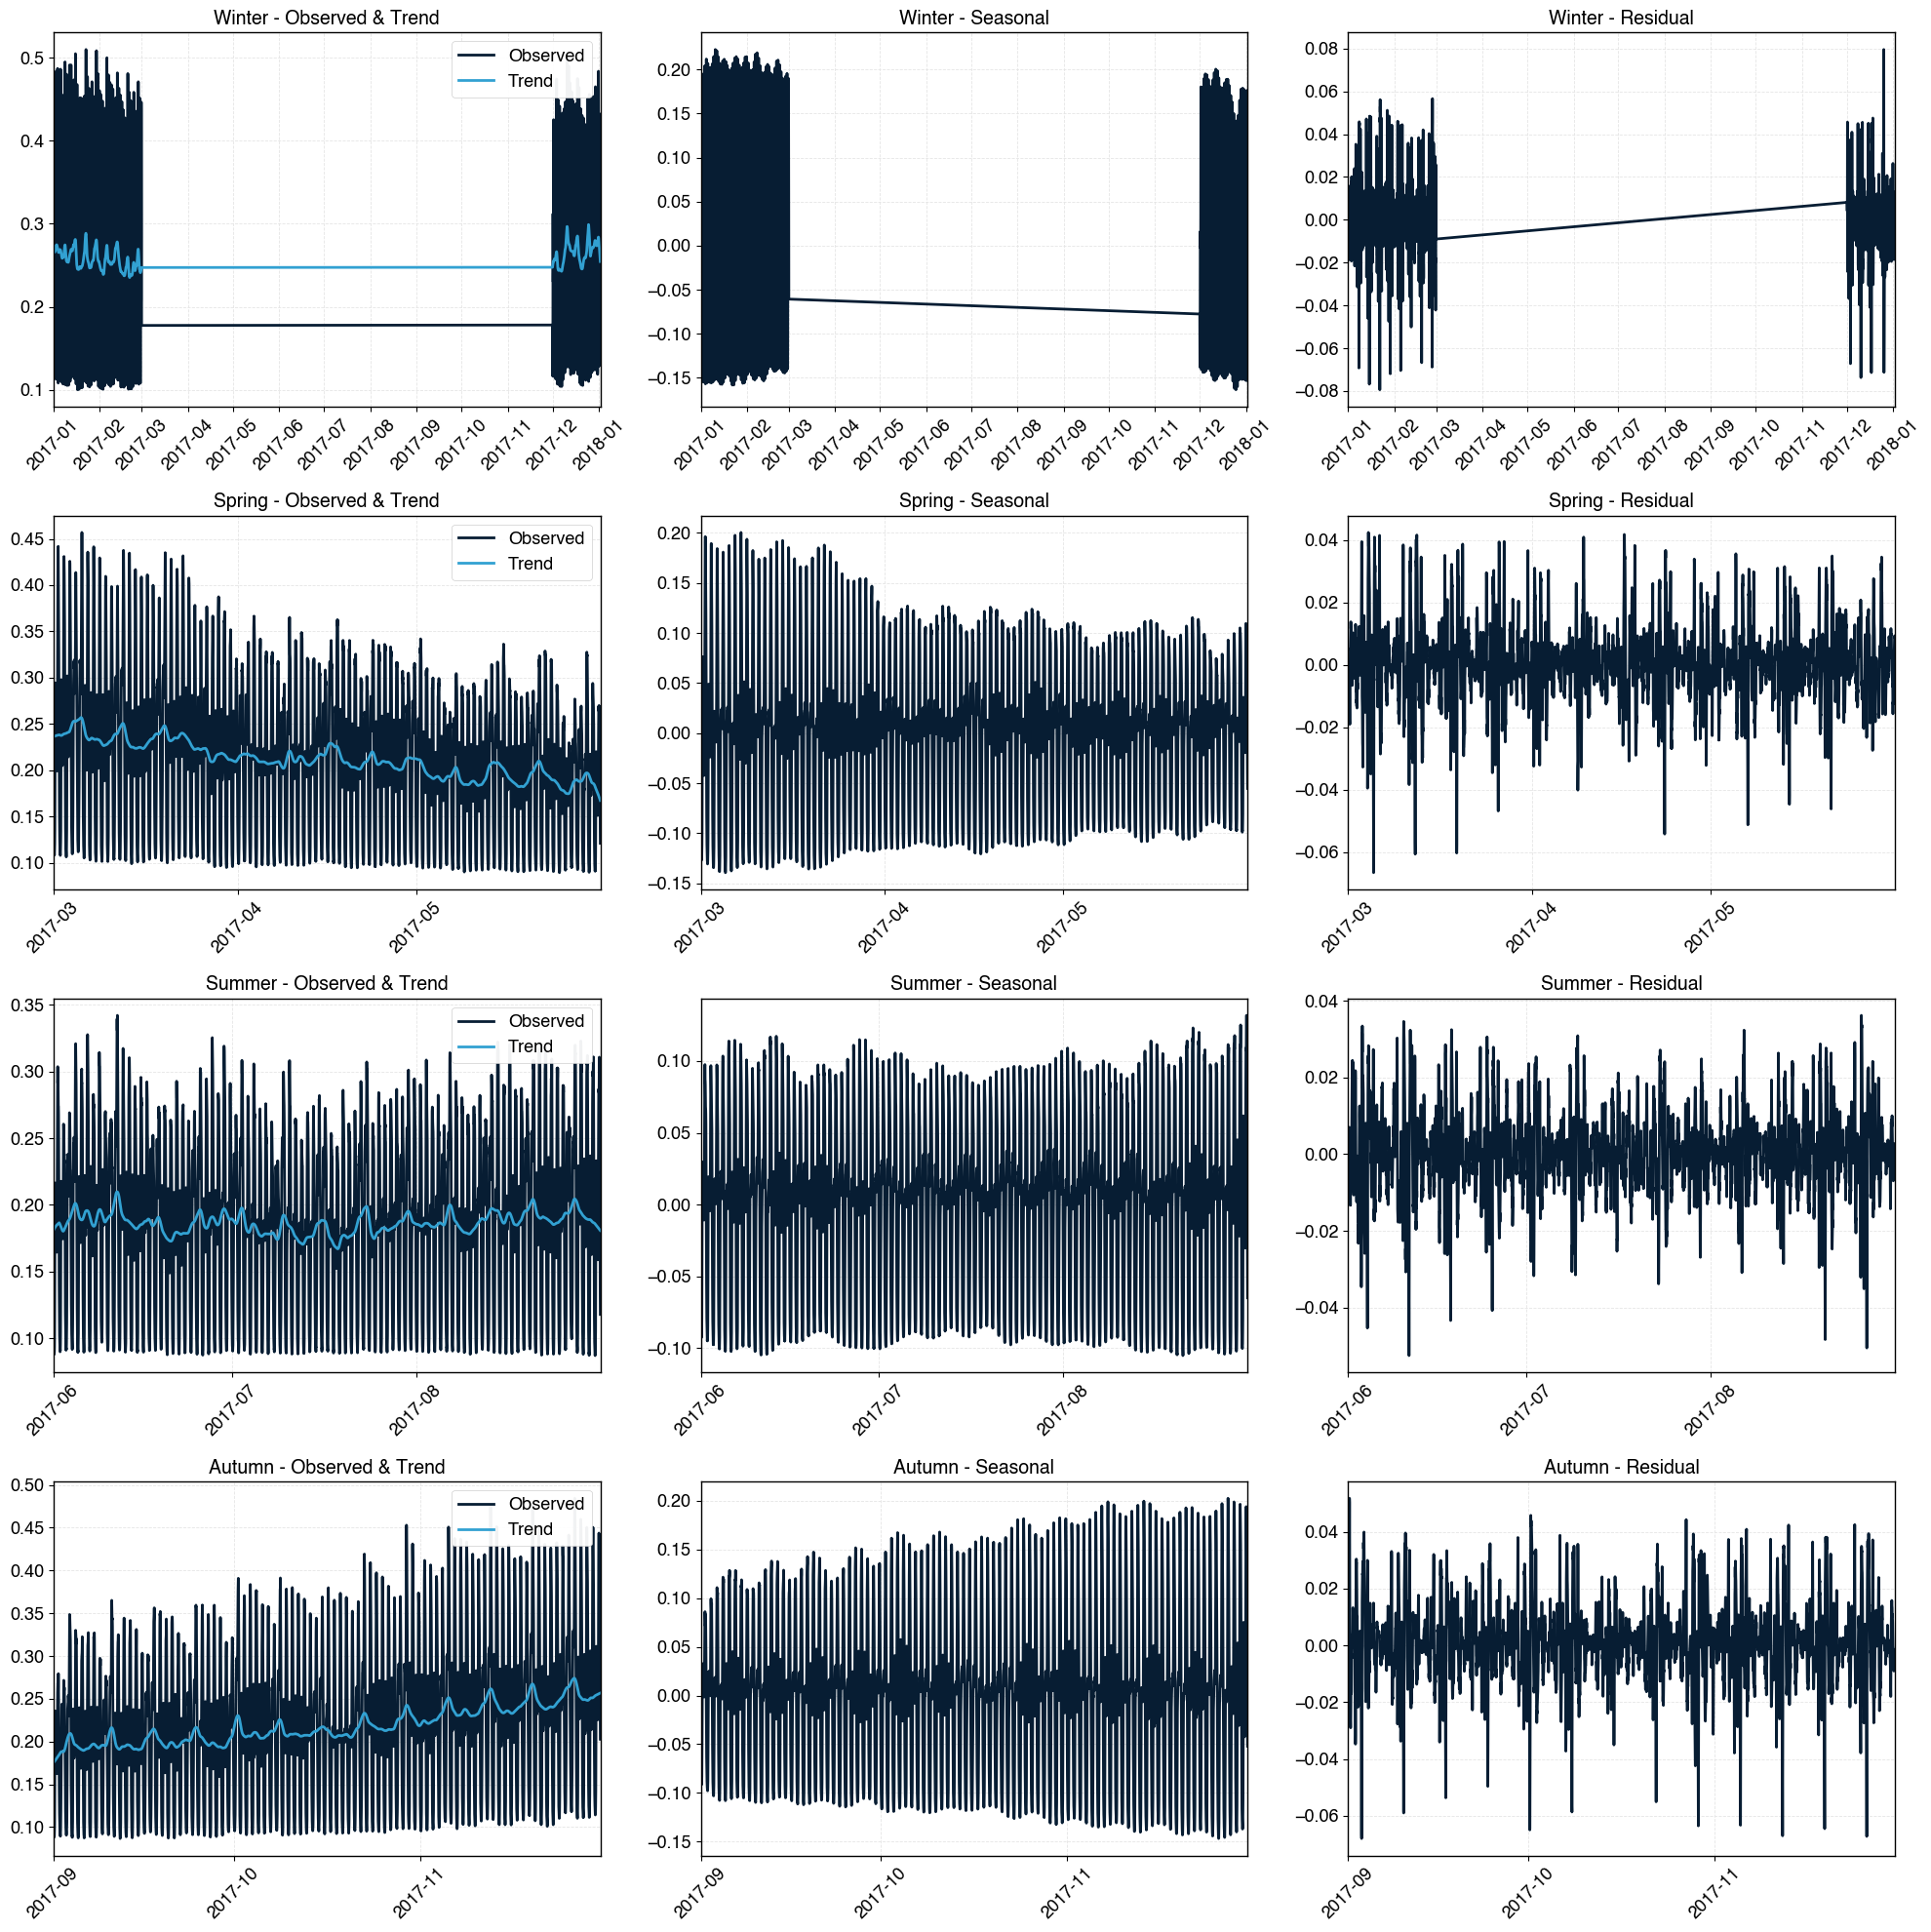

In [40]:
import matplotlib.dates as mdates

seasons = ts_rd['Season'].unique()
fig, axs = plt.subplots(len(seasons), 3, figsize=(20, 20), sharex=False)

for i, season in enumerate(seasons):
    seasonal_df = ts_rd[ts_rd['Season'] == season]
    stl = STL(seasonal_df['Demand_mean_kw'], period=48)
    res = stl.fit()

    # Get start and end for consistent x-axis
    x_start = seasonal_df.index.min()
    x_end = seasonal_df.index.max()

    # Observed + trend
    axs[i, 0].plot(seasonal_df.index, seasonal_df['Demand_mean_kw'], label='Observed')
    axs[i, 0].plot(seasonal_df.index, res.trend, label='Trend')
    axs[i, 0].set_title(f'{season} - Observed & Trend')
    axs[i, 0].legend()

    # Seasonal
    axs[i, 1].plot(seasonal_df.index, res.seasonal)
    axs[i, 1].set_title(f'{season} - Seasonal')

    # Residual
    axs[i, 2].plot(seasonal_df.index, res.resid)
    axs[i, 2].set_title(f'{season} - Residual')

    # Format x-axis for all three
    for ax in axs[i]:
        ax.set_xlim([x_start, x_end])
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

Looking at the STL plots for each season, we can see clear changes in how people use electricity throughout the year. In winter, demand stays pretty steady at first, then shoots up toward the end of the season. The trend line backs that up, showing a big rise in overall usage most likely because it’s colder and darker, so people are using more heating and lights. The seasonal pattern doesn’t really kick in until later in the winter, which could mean more consistent daily routines or heavier use during mornings and evenings. The residuals in winter are a bit all over the place, especially as demand ramps up, suggesting there might have been some unusual events or just more unpredictable usage.

Spring demand decreases slowly as the season ended, this mark the end of spring where weather is getting warmer day by day. We can see it clearly in the seasonal graph.

Summer looks more stable than any other season. the trend doesnt deviate that much as well as the seasonal aspect. This is also suggested by the residual plot where we can see it is between 0.4 and -0.4 where as other season might jump to -0.6 to -0.8.

Autum is the opposite of spring, demand started low and increases towards the end of the season

### Stationary Test

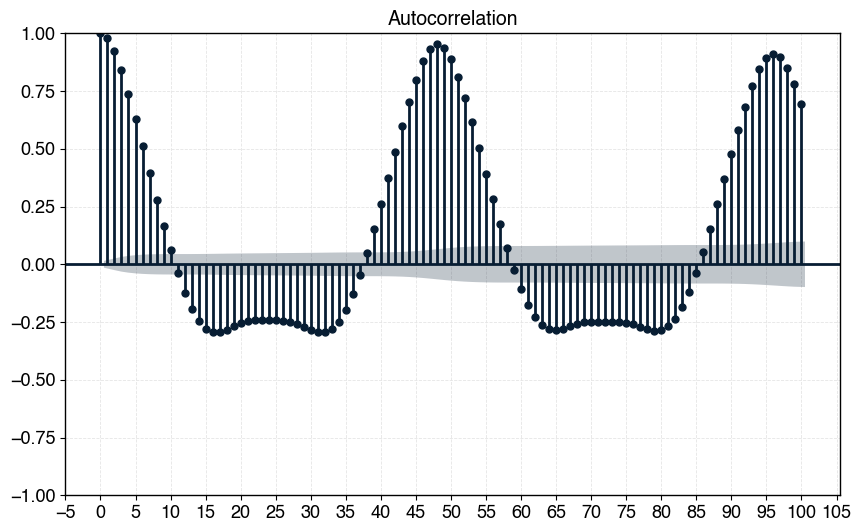

In [41]:
from matplotlib.ticker import MultipleLocator
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size here
#set tick to every 5th value like 0, 5 
plot_acf(ts_rd['Demand_mean_kw'], lags=100, ax=ax)
ax.xaxis.set_major_locator(MultipleLocator(5))
plt.show()

The auto correlation plot shows strong spike at lag 48. This correlate with our data that have interval of 30 minute that means in a day there will be in total 48 points.

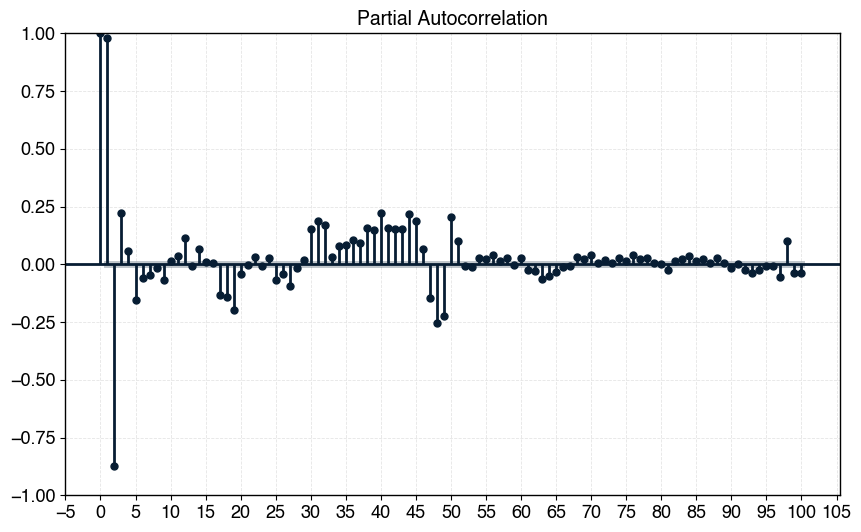

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size here
plot_pacf(ts_rd['Demand_mean_kw'], lags=100, ax=ax)
ax.xaxis.set_major_locator(MultipleLocator(5))
plt.show()


A spike is present at lag 1 this means that there's a direct, strong positive relationship between the current value and the previous half-hour’s demand. However lag 2 shows a negative strong lag meaning the value two half-hours ago (1 hour ago) pulls the demand in the opposite direction after accounting for lag 1. This suggests that after a short rise in demand, there's often a quick drop like a correction of some sort. 

It might be due to for example, people might switch on appliances or heating for a short period, leading to a spike, but then usage falls soon after as those devices switch off or aren't needed anymore or the device is in idle. This kind of up-and-down pattern in a short time frame is common in residential settings, especially in the morning or evening when people are active for a limited window. The PACF structure points to a model where both lag 1 and lag 2 are important, possibly indicating short term oscillations in usage behavior.

## Energy Consumption

In [43]:
ts_rd['Res_energy_kwh'] = ts_rd['Demand_mean_kw'] * 0.5  # Assuming 0.5 households per kW
ts_rd['Res_total_energy_kwh'] = ts_rd['Res_energy_kwh'] * 10385   # Assuming 1000 households

daily_consumption = ts_rd.groupby("Date")["Res_energy_kwh"].sum().reset_index()
avg_daily_consumption = daily_consumption['Res_energy_kwh'].mean()
max_consumption = daily_consumption['Res_energy_kwh'].max()
annual_consumption = daily_consumption['Res_energy_kwh'].sum()

print(f"Annual consumption: {annual_consumption:.2f} kWh")
print(f"Average daily consumption: {avg_daily_consumption:.2f} kWh")
print(f"Min daily consumption: {daily_consumption['Res_energy_kwh'].min():.2f} kWh")
print(f"Max daily consumption: {max_consumption:.2f} kWh")



Annual consumption: 1924.49 kWh
Average daily consumption: 5.26 kWh
Min daily consumption: 4.01 kWh
Max daily consumption: 7.14 kWh


this is so low?? maybe cause only 41% use electric heating or it is controled? or maybe its a small house. a typical uk energy usage for a flat or 1-bedroom house is 4.93

Possible Appliances that can reach a max 7.14 kWh?:
* Fridge + Freezer 
* Dishwasher
* Oven


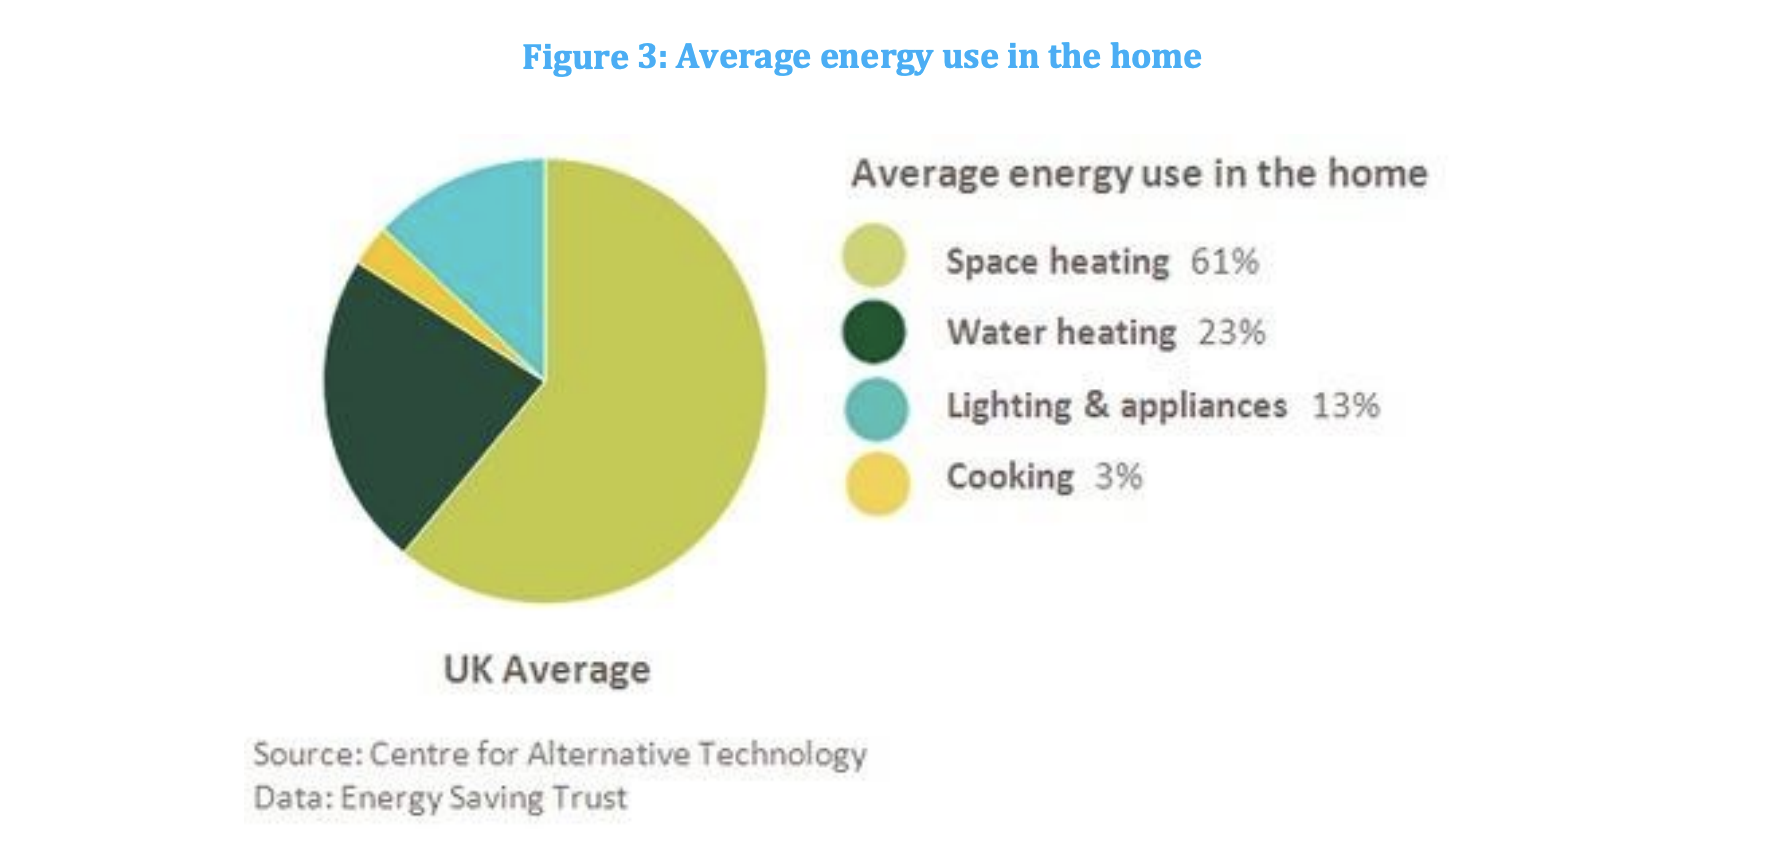

In [44]:

# Note: Lets say we add extra energy for household that use electricity for heating, cause our number is too low
# lets assume that the daily consumption is only for cooking, lighting and other appliances
# but we find that electric heating is around 60% of total energy consumption of a household
# so we can add 60% of the average daily consumption to the total energy consumption

electricity_heating_factor = 0.7
electricity_heating_energy = avg_daily_consumption * (electricity_heating_factor/(1-electricity_heating_factor))

print(f"Average daily consumption baseline: {avg_daily_consumption:.2f}")
print(f"Average daily consumption with electric heating: {electricity_heating_energy:.2f} kWh")
print(f"Average total daily consumption: {(avg_daily_consumption+electricity_heating_energy):.2f}")

print(f"Annual consumption baseline: {annual_consumption:.2f} kWh")
print(f"Annual consumption with electric heating: {(annual_consumption+electricity_heating_energy*365):.2f} kWh")

electricity_heating_energy/(avg_daily_consumption+electricity_heating_energy)

Average daily consumption baseline: 5.26
Average daily consumption with electric heating: 12.27 kWh
Average total daily consumption: 17.53
Annual consumption baseline: 1924.49 kWh
Annual consumption with electric heating: 6402.70 kWh


np.float64(0.6999999999999998)

In [46]:
# Average daily consumption per season
seasonal_consumption = ts_rd.groupby(['Season', 'Date'])['Res_energy_kwh'].sum().reset_index()
seasonal_consumption = seasonal_consumption.groupby('Season')['Res_energy_kwh'].mean().reset_index()

seasonal_consumption

Season  Res_energy_kwh
0  Autumn        5.247790
1  Spring        5.076958
2  Summer        4.477544
3  Winter        6.240957

## Peak and Off-Peak Hour


In [47]:
ts_rd.head()

Demand_mean_kw  N_households  Month_int        Date  \
Timestamp                                                                  
2017-01-01 00:00:00        0.220106          5428          1  2017-01-01   
2017-01-01 00:30:00        0.205945          5429          1  2017-01-01   
2017-01-01 01:00:00        0.189090          5429          1  2017-01-01   
2017-01-01 01:30:00        0.173118          5429          1  2017-01-01   
2017-01-01 02:00:00        0.159051          5429          1  2017-01-01   

                     Season  Res_energy_kwh  Res_total_energy_kwh  
Timestamp                                                          
2017-01-01 00:00:00  Winter        0.110053           1142.902923  
2017-01-01 00:30:00  Winter        0.102973           1069.369982  
2017-01-01 01:00:00  Winter        0.094545            981.849242  
2017-01-01 01:30:00  Winter        0.086559            898.915577  
2017-01-01 02:00:00  Winter        0.079525            825.870520

Mean: 0.22 kW


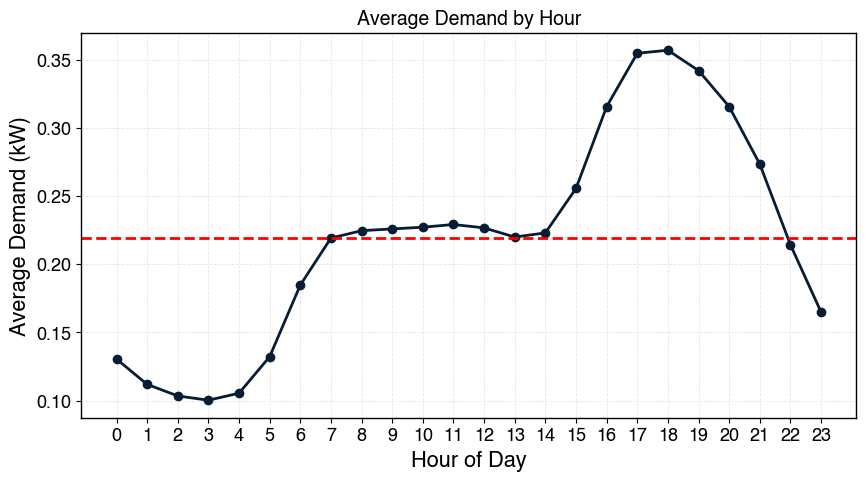

In [48]:
ts_rd['Hour'] = ts_rd.index.hour
ts_rd['Day'] = ts_rd.index.date

hourly_avg = ts_rd.groupby('Hour')['Demand_mean_kw'].mean().reset_index()

print(f'Mean: {hourly_avg["Demand_mean_kw"].mean():.2f} kW')

plt.figure(figsize=(10, 5))
plt.plot(hourly_avg['Hour'], hourly_avg['Demand_mean_kw'], marker='o')
# plot mean line
plt.axhline(y=hourly_avg['Demand_mean_kw'].mean(), color='r', linestyle='--', label='Mean')
plt.title("Average Demand by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Demand (kW)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

### Demand Per Hour For Each Season

In [71]:
hourly_avg_per_season

Season    Winter    Spring    Summer    Autumn
Hour                                          
0       0.164533  0.123226  0.109295  0.125274
1       0.134605  0.107864  0.097179  0.108103
2       0.120622  0.101049  0.091620  0.100540
3       0.113210  0.099326  0.090759  0.097869
4       0.113049  0.106455  0.097745  0.104478
5       0.124906  0.139527  0.129420  0.134886
6       0.174509  0.195158  0.174471  0.194898
7       0.240831  0.222588  0.188056  0.225752
8       0.256189  0.224338  0.194445  0.223978
9       0.259887  0.222969  0.199736  0.221519
10      0.267096  0.220450  0.200495  0.221146
11      0.270912  0.220437  0.203183  0.222619
12      0.277689  0.214568  0.195128  0.219945
13      0.273967  0.205993  0.187344  0.213102
14      0.269543  0.210515  0.193992  0.218552
15      0.291815  0.243800  0.229371  0.257968
16      0.364621  0.296421  0.275387  0.326776
17      0.439977  0.324753  0.284545  0.371049
18      0.448148  0.334166  0.276423  0.370614
19      0.420840  0.330796  0.268144  0.349680
20      0.384208  0.310214  0.255246  0.313886
21      0.337754  0.266106  0.226957  0.263789
22      0.278021  0.202530  0.174164  0.203261
23      0.214026  0.153709  0.134439  0.158107

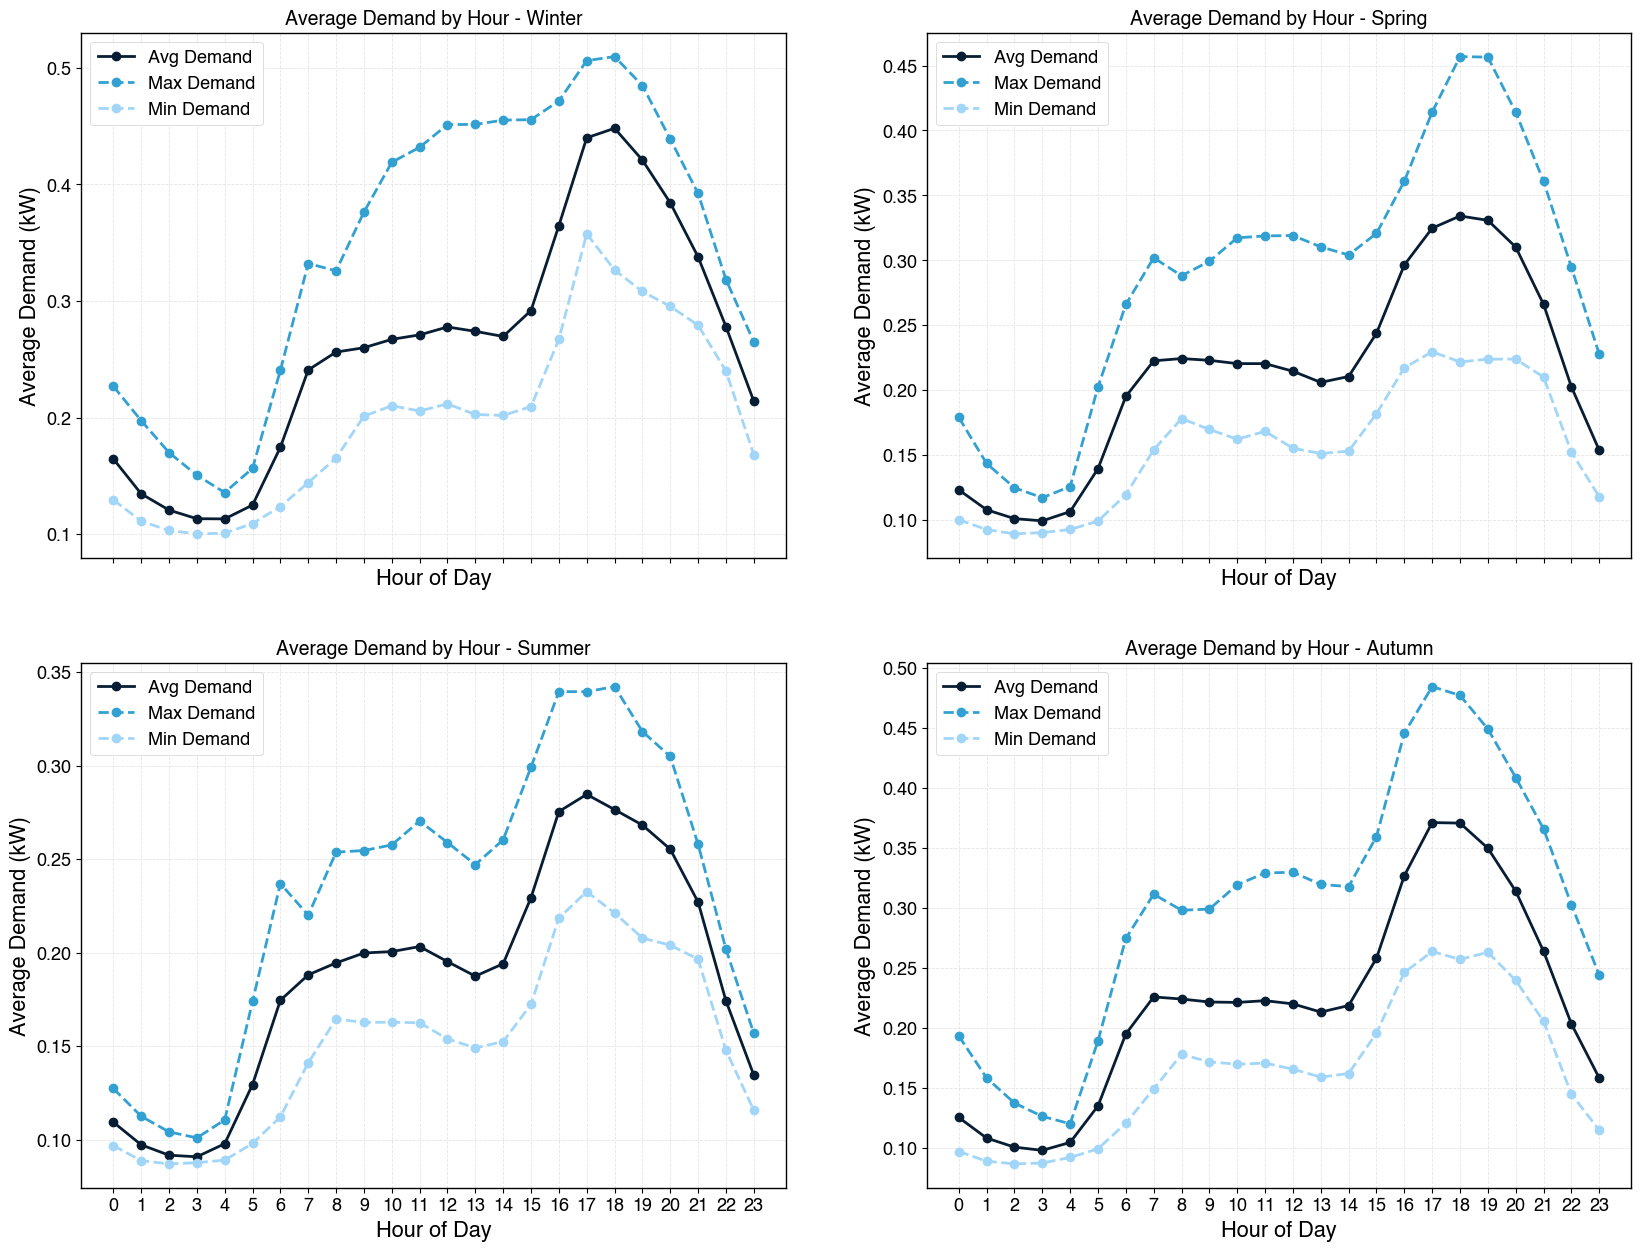

In [49]:
hourly_avg_per_season = ts_rd.groupby(['Hour', 'Season'])['Demand_mean_kw'].mean().unstack()
hourly_avg_per_season = hourly_avg_per_season.reindex(columns=['Winter', 'Spring', 'Summer', 'Autumn'])
max_demand_per_hour_per_season = ts_rd.groupby(['Hour', 'Season'])['Demand_mean_kw'].max().unstack()
max_demand_per_hour_per_season = max_demand_per_hour_per_season.reindex(columns=['Winter', 'Spring', 'Summer', 'Autumn'])
min_demand_per_hour_per_season = ts_rd.groupby(['Hour', 'Season'])['Demand_mean_kw'].min().unstack()
min_demand_per_hour_per_season = min_demand_per_hour_per_season.reindex(columns=['Winter', 'Spring', 'Summer', 'Autumn'])


# Plot the data on seperate subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15), sharex=True)
axs = axs.flatten()
for i, season in enumerate(hourly_avg_per_season.columns):
    axs[i].plot(hourly_avg_per_season.index, hourly_avg_per_season[season], marker='o', label='Avg Demand')
    # Max Demand for the season by hour
    axs[i].plot(max_demand_per_hour_per_season.index, max_demand_per_hour_per_season[season], marker='o', linestyle='--', label='Max Demand')
    # Min Demand for the season by hour
    axs[i].plot(min_demand_per_hour_per_season.index, min_demand_per_hour_per_season[season], marker='o', linestyle='--', label='Min Demand')
    axs[i].legend(loc ='upper left')
    axs[i].set_title(f"Average Demand by Hour - {season}")
    axs[i].set_xlabel("Hour of Day")
    axs[i].set_ylabel("Average Demand (kW)")
    axs[i].grid(True)
    axs[i].set_xticks(range(0, 24))


In [50]:
peak_hours = {}
for i, season in enumerate(hourly_avg_per_season.columns):
    peak_hours_season = hourly_avg_per_season[season][hourly_avg_per_season[season] > (hourly_avg_per_season[season].mean()+0.03)].index.tolist()
    peak_hours[season] = peak_hours_season

    
# Print peak hours for each Season
for season, hours in peak_hours.items():
    print(f"Peak hours for {season}: {hours}")
    print(f'Off-peak hours for {season}: {[h for h in range(0, 24) if h not in hours]}')
    print('')

Peak hours for Winter: [15, 16, 17, 18, 19, 20, 21]
Off-peak hours for Winter: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22, 23]

Peak hours for Spring: [15, 16, 17, 18, 19, 20, 21]
Off-peak hours for Spring: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22, 23]

Peak hours for Summer: [15, 16, 17, 18, 19, 20, 21]
Off-peak hours for Summer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22, 23]

Peak hours for Autumn: [15, 16, 17, 18, 19, 20, 21]
Off-peak hours for Autumn: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22, 23]



## Clustering

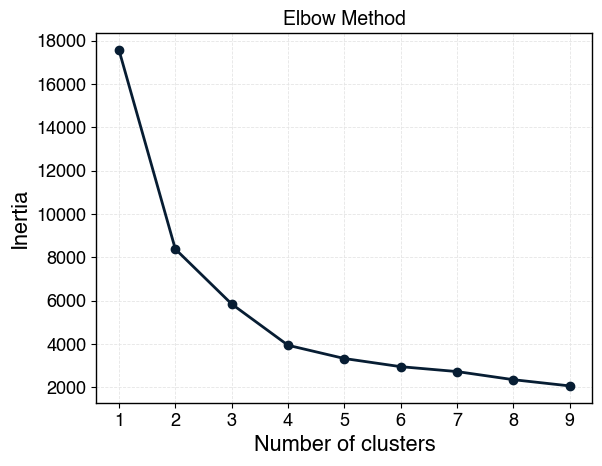

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

ts_rd['Time'] = ts_rd.index.time  # Extracts time like 00:00:00, 00:30:00, ...
daily_profiles = ts_rd.pivot_table(
    index='Date', columns='Time', values='Demand_mean_kw'
)


X = StandardScaler().fit_transform(daily_profiles.fillna(0))  # or dropna()


inertias = []
K = range(1, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=0).fit(X)
    inertias.append(model.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


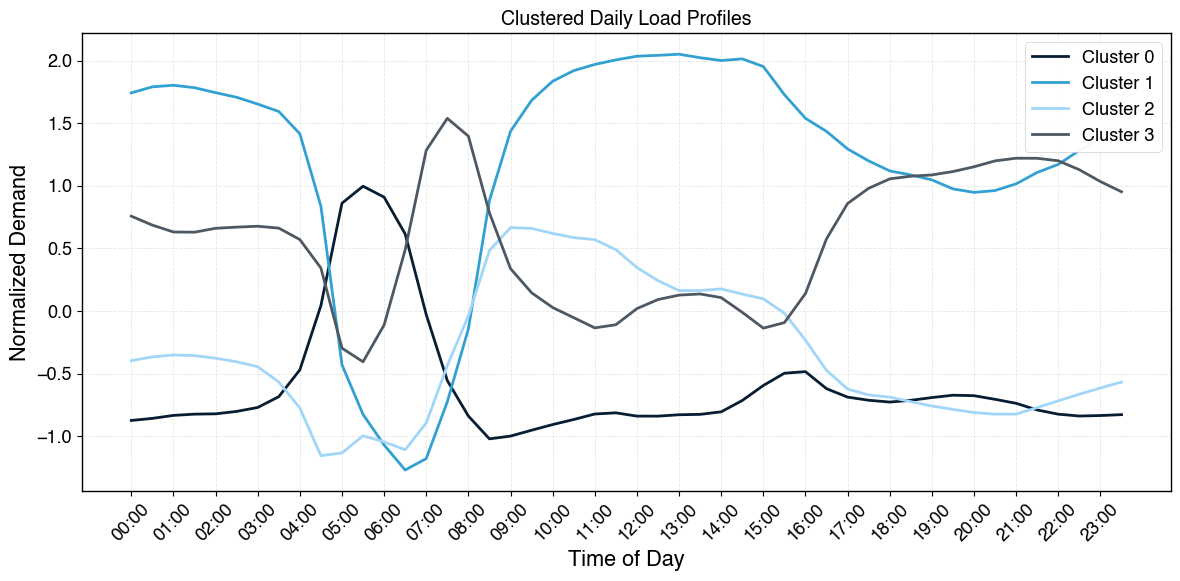

In [52]:
kmeans = KMeans(n_clusters=4, random_state=0)
daily_profiles['cluster'] = kmeans.fit_predict(X)

daily_profiles['cluster'] = kmeans.labels_
daily_profiles = daily_profiles.reset_index()  # This brings 'Date' from index to column
daily_profiles['Date'] = pd.to_datetime(daily_profiles['Date'])

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(kmeans.n_clusters):
    cluster_center = kmeans.cluster_centers_[i]
    plt.plot(cluster_center, label=f'Cluster {i}')
# Set x-axis ticks every hour (i.e., every 2 steps)
x_ticks = np.arange(0, 48, 2)
x_labels = [f'{h:02d}:00' for h in range(24)]

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

plt.xticks(rotation=45)

ax.set_title('Clustered Daily Load Profiles')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Normalized Demand')
ax.legend()
plt.tight_layout()
plt.show()

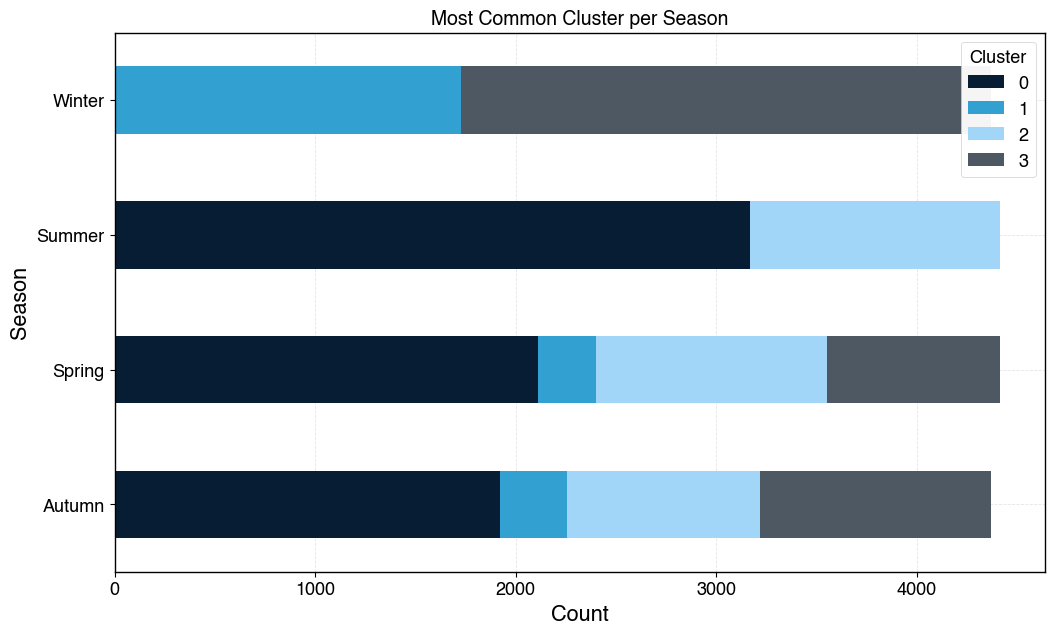

In [53]:
df_clustered = ts_rd.copy()
# Ensure 'Date' is in both dataframes and properly formatted
df_clustered['Date'] = pd.to_datetime(df_clustered['Date'])

df_clustered = df_clustered.merge(
    daily_profiles[['Date', 'cluster']],
    on='Date',
    how='left'
)


# Most common cluster per season
cluster_season = df_clustered.groupby(['Season', 'cluster']).size().unstack()

fig, ax = plt.subplots(figsize=(12, 7))

cluster_season.plot(kind='barh', stacked=True, ax=ax)
ax.set_title('Most Common Cluster per Season')
ax.set_xlabel('Count')
ax.set_ylabel('Season')
ax.legend(title='Cluster')
plt.show()





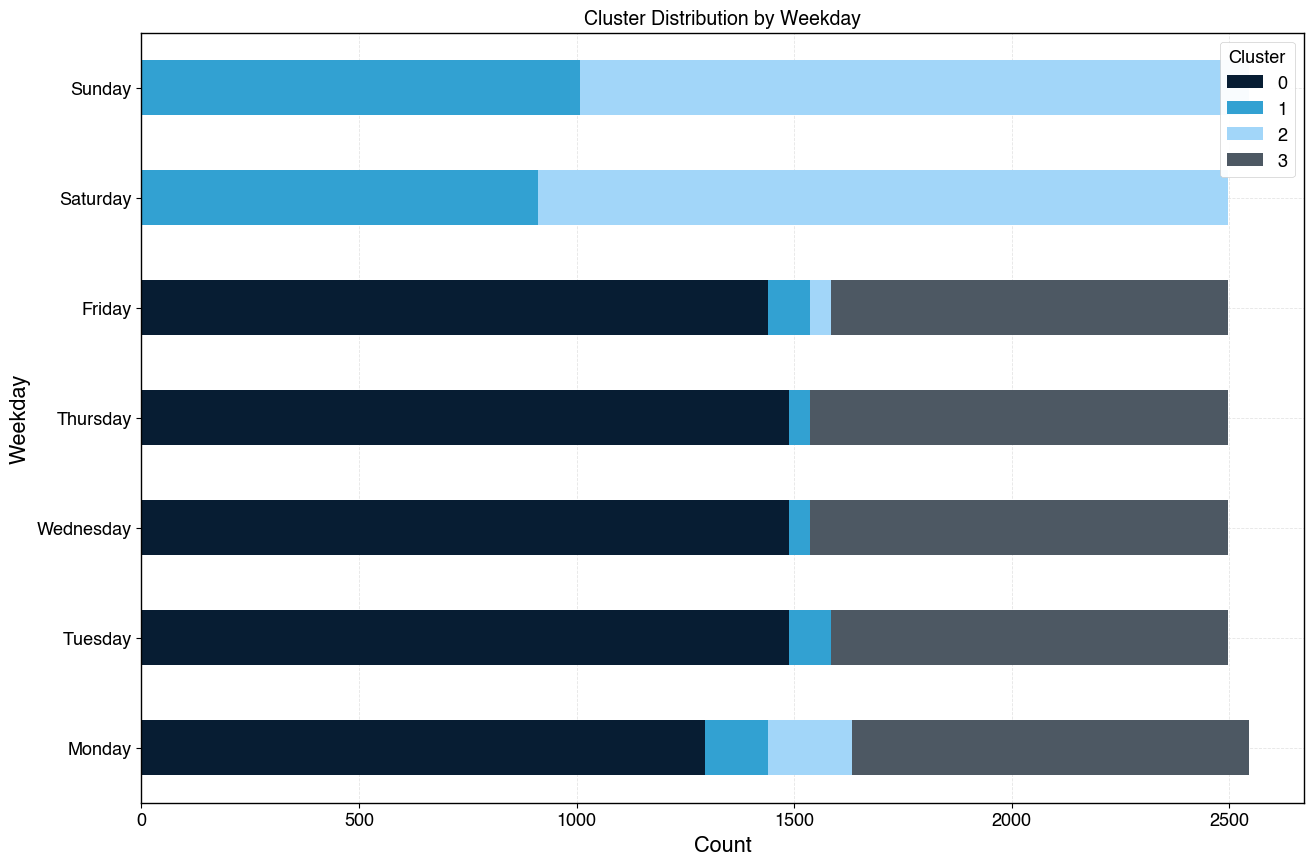

In [54]:
# Cluster counts per weekday
df_clustered['weekday'] = pd.to_datetime(df_clustered['Date']).dt.day_name()

cluster_weekday = df_clustered.groupby(['weekday', 'cluster']).size().unstack().loc[
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
]

fig, ax = plt.subplots(figsize=(15,10))

cluster_weekday.plot(kind='barh', stacked=True, ax=ax)
ax.set_title('Cluster Distribution by Weekday')
ax.set_ylabel('Weekday')
ax.set_xlabel('Count')
ax.legend(title='Cluster')
# plt.tight_layout()
plt.show()

In [ ]:
ts

# Curtailment

In [54]:
ts_rd.head()

Demand_mean_kw  N_households  Month_int        Date  \
Timestamp                                                                  
2017-01-01 00:00:00        0.220106          5428          1  2017-01-01   
2017-01-01 00:30:00        0.205945          5429          1  2017-01-01   
2017-01-01 01:00:00        0.189090          5429          1  2017-01-01   
2017-01-01 01:30:00        0.173118          5429          1  2017-01-01   
2017-01-01 02:00:00        0.159051          5429          1  2017-01-01   

                     Season  Res_energy_kwh  Res_total_energy_kwh  Hour  \
Timestamp                                                                 
2017-01-01 00:00:00  Winter        0.110053           1142.902923     0   
2017-01-01 00:30:00  Winter        0.102973           1069.369982     0   
2017-01-01 01:00:00  Winter        0.094545            981.849242     1   
2017-01-01 01:30:00  Winter        0.086559            898.915577     1   
2017-01-01 02:00:00  Winter        0.079525            825.870520     2   

                            Day      Time  
Timestamp                                  
2017-01-01 00:00:00  2017-01-01  00:00:00  
2017-01-01 00:30:00  2017-01-01  00:30:00  
2017-01-01 01:00:00  2017-01-01  01:00:00  
2017-01-01 01:30:00  2017-01-01  01:30:00  
2017-01-01 02:00:00  2017-01-01  02:00:00

In [61]:

# Merge using the index since both DataFrames have Timestamp as the index
ts_curtailment = pd.merge(
    ts_dropped[['Final_wind_ms','Temperature (C)', 'Turbine_power_kw', 'Turbine_energy_kwh']].rename(columns={'Final_wind_ms': 'Wind_ms', 'Temperature (C)': 'Temperature_c'}),
    ts_rd[['Demand_mean_kw','Res_energy_kwh','Season','Day', 'Time','Hour']].rename(columns={'Demand_mean_kw': 'Res_demand_kw'}),
    left_index=True,
    right_index=True,
    how='left'
)

ts_curtailment.head()
# Check data from ts_rd that is not available in ts_curtailment
# ts_rd[~ts_rd.index.isin(ts_curtailment.index)].head(5)

# ts_curtailment.to_csv(PROCESSED_DATASET_PATH / 'ts_curtailment.csv', index=True)

Wind_ms  Temperature_c  Turbine_power_kw  \
Timestamp                                                         
2017-01-01 00:00:00  13.820000            NaN        894.033333   
2017-01-01 00:30:00  16.106667            5.0        898.266667   
2017-01-01 01:00:00  16.380000            6.1        902.866667   
2017-01-01 01:30:00  17.083333            5.0        907.833333   
2017-01-01 02:00:00  16.800000            3.9        907.000000   

                     Turbine_energy_kwh  Res_demand_kw  Res_energy_kwh  \
Timestamp                                                                
2017-01-01 00:00:00          447.016667       0.220106        0.110053   
2017-01-01 00:30:00          449.133333       0.205945        0.102973   
2017-01-01 01:00:00          451.433333       0.189090        0.094545   
2017-01-01 01:30:00          453.916667       0.173118        0.086559   
2017-01-01 02:00:00          453.500000       0.159051        0.079525   

                     Season         Day      Time  Hour  
Timestamp                                                
2017-01-01 00:00:00  Winter  2017-01-01  00:00:00     0  
2017-01-01 00:30:00  Winter  2017-01-01  00:30:00     0  
2017-01-01 01:00:00  Winter  2017-01-01  01:00:00     1  
2017-01-01 01:30:00  Winter  2017-01-01  01:30:00     1  
2017-01-01 02:00:00  Winter  2017-01-01  02:00:00     2

In [ ]:
def calculate_curtailment(df, n_dwelling= 10358, n_turbine= 500, max_export= 40):
    """
    Calculate curtailment based on the difference between wind power and residential demand.
    
    Parameters:
    df (DataFrame): DataFrame containing wind power and residential demand data.
    n_dwelling (int): Number of dwellings.
    n_turbine (int): Number of turbines.
    max_export (float): Maximum export capacity in kW.
    
    Returns:
    DataFrame: DataFrame with curtailment calculations.
    """
    Max_export_kwh = (max_export/2) * 1000 # kWh
    
    
    df['Res_energy_total_kwh'] = df['Res_demand_kw'] * 0.5 * n_dwelling
    
    # Assumption for electric heating
    # df['Res_energy_electric_heating_kwh']

    df['Turbine_energy_total_kwh'] = df['Turbine_energy_kwh'] * n_turbine
    
    df['Excess_energy'] = df['Turbine_energy_total_kwh'] - df['Res_energy_total_kwh']
    
    df['Export_probability'] = np.random.rand(len(df))
    
    df['Can_export'] = (
    (df['Export_probability'] < 0.7)  # 70% of the time
    )

    df['Export_energy_kwh'] = (
    df['Excess_energy'].clip(lower=0, upper=Max_export_kwh) * df['Can_export'])

    df['Curtailment_energy_kwh'] = (df['Turbine_energy_total_kwh'] - df['Res_energy_total_kwh'] - df['Export_energy_kwh'])
    
    return df

n_turbine = 500
n_dwelling = 10358

calculate_curtailment(ts_curtailment, n_turbine=n_turbine, n_dwelling=n_dwelling, max_export=40)

ts_curtailment.head()

# ts_curtailment.to_csv(PROCESSED_DATASET_PATH / 'ts_curtailment_calculated.csv', index=True)

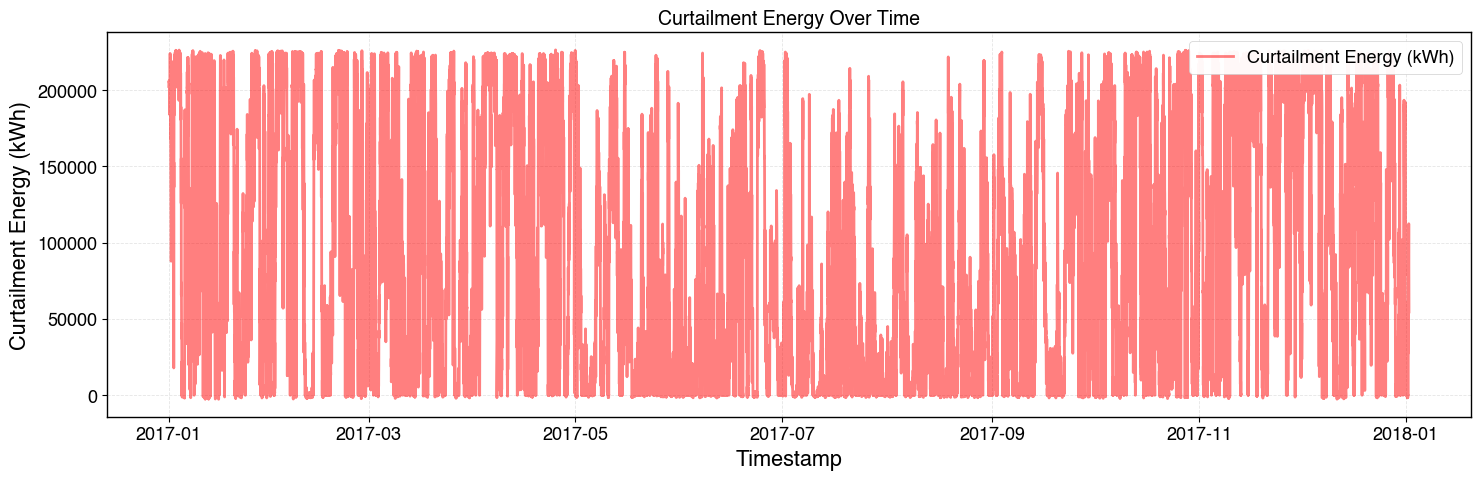

In [64]:
# Plot curtailment energy over time
plt.figure(figsize=(15, 5))
plt.plot(ts_curtailment.index, ts_curtailment['Curtailment_energy_kwh'], label='Curtailment Energy (kWh)', color='red', alpha=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Curtailment Energy (kWh)')
plt.title('Curtailment Energy Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

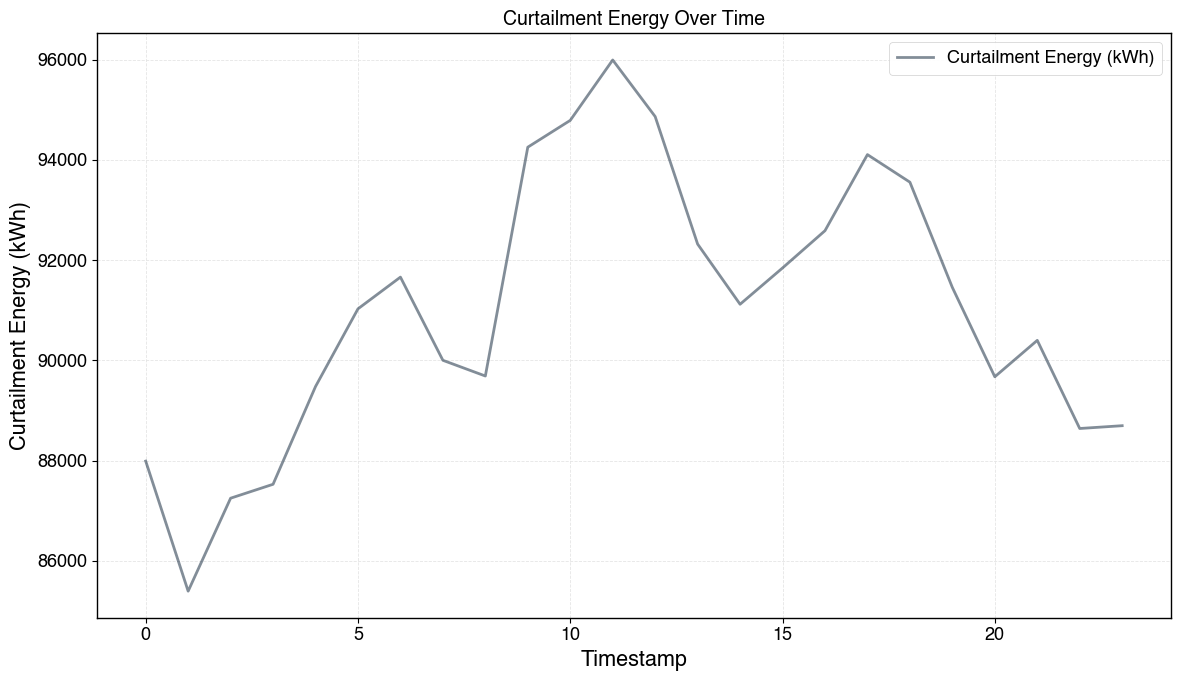

In [65]:
hourly_curtailment = ts_curtailment.groupby('Hour')[['Curtailment_energy_kwh', 'Turbine_energy_kwh']].mean().reset_index()


# plot the curtailment and generated energy on a line plot and put the a
plt.figure(figsize=(12, 7))
plt.plot(hourly_curtailment.index, hourly_curtailment['Curtailment_energy_kwh'], label='Curtailment Energy (kWh)', alpha=0.5)

plt.xlabel('Timestamp')
plt.ylabel('Curtailment Energy (kWh)')
plt.title('Curtailment Energy Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [141]:
ts_curtailment['Curtailment_energy_kwh'].sum()/(10**3)
#Sum curtailment when positive only
ts_curtailment['Curtailment_energy_kwh'][ts_curtailment['Curtailment_energy_kwh'] > 0].sum()/(10**6)

np.float64(1662.726519947011)

In [142]:
((ts_curtailment['Res_demand_kw']*0.5).sum())

np.float64(1918.2873466809729)

In [70]:
(((ts_curtailment['Res_energy_total_kwh']).sum()))/(10**6)

# MW -> Gw 10^3
# (20*24*365)/(10**3)

np.float64(19.869620336921518)

In [69]:
(ts_curtailment['Export_energy_kwh'].sum()/(10**6))



np.float64(203.30789024320683)

In [68]:
(ts_curtailment['Turbine_energy_total_kwh'].sum())/(10**6)

np.float64(1816.529653612186)

In [67]:
(ts_curtailment['Curtailment_energy_kwh'].sum()/(10**6))

np.float64(1593.3521430320577)

In [147]:
(40*24*365)/(10**3)

350.4

In [ ]:
df_tt_og.Timestamp = pd.to_datetime(df_tt_og.Timestamp)

df_tt_og_2017 = df_tt_og[df_tt_og.Timestamp.dt.year == 2017]

((df_tt_og_2017['Power_kw']/60).sum())/(10**6)

np.float64(3.3971446333333333)

In [ ]:
ts_tt_og_2017

Power_kw  Setpoint_kw  Wind_ms
Timestamp                                          
2017-01-01 00:00:20     900.0        900.0     13.1
2017-01-01 00:01:20     756.0        900.0     12.4
2017-01-01 00:02:20     907.0        900.0     13.8
2017-01-01 00:03:20     906.0        900.0     13.3
2017-01-01 00:04:20     860.0        900.0     12.9
...                       ...          ...      ...
2017-12-31 23:55:32      53.0        900.0      4.9
2017-12-31 23:56:32      54.0        900.0      5.0
2017-12-31 23:57:32      67.0        900.0      5.1
2017-12-31 23:58:32      63.0        900.0      5.6
2017-12-31 23:59:32      74.0        900.0      5.4

[496149 rows x 3 columns]

In [ ]:
ts_tt_og_2017 = df_tt_og_2017.set_index('Timestamp').copy()
ts_resampled_no_imputation = ts_tt_og_2017.resample('1min').agg({
    'Power_kw': ['mean','count'],
    'Setpoint_kw': 'max',
    'Wind_ms': 'mean',
}).reset_index()

#flatten the columns names in the resampled aggregation
ts_resampled_no_imputation.columns = ['_'.join(col).strip() if col[1] else col[0] for col in ts_resampled_no_imputation.columns.values]
ts_resampled_no_imputation

(ts_resampled_no_imputation['Power_kw_mean'].sum() / ts_resampled_no_imputation['Power_kw_count'].sum() )
# calculate the 2017 total energy



np.float64(411.1161180918495)

In [ ]:
ts_resampled_no_imputation

Timestamp  Power_kw_mean  Power_kw_count  Setpoint_kw_max  \
0      2017-01-01 00:00:00          900.0               1            900.0   
1      2017-01-01 00:01:00          756.0               1            900.0   
2      2017-01-01 00:02:00          907.0               1            900.0   
3      2017-01-01 00:03:00          906.0               1            900.0   
4      2017-01-01 00:04:00          860.0               1            900.0   
...                    ...            ...             ...              ...   
525595 2017-12-31 23:55:00           53.0               1            900.0   
525596 2017-12-31 23:56:00           54.0               1            900.0   
525597 2017-12-31 23:57:00           67.0               1            900.0   
525598 2017-12-31 23:58:00           63.0               1            900.0   
525599 2017-12-31 23:59:00           74.0               1            900.0   

        Wind_ms_mean  
0               13.1  
1               12.4  
2               13.8  
3               13.3  
4               12.9  
...              ...  
525595           4.9  
525596           5.0  
525597           5.1  
525598           5.6  
525599           5.4  

[525600 rows x 5 columns]

In [ ]:
valid_df = ts_resampled_no_imputation[ts_resampled_no_imputation['Power_kw_mean'].notna()]

# Step 2: Calculate energy per row in kWh
valid_df['energy_kwh'] = (valid_df['Power_kw_mean'] / valid_df['Power_kw_count']) * (1/60)  # because 1 minute = 1/60 hour

# Step 3: Sum to get total yearly energy
total_energy_kwh = valid_df['energy_kwh'].sum()

print(f"Total energy generated over the year: {total_energy_kwh:.2f} kWh")

Total energy generated over the year: 3385868.71 kWh


/var/folders/9s/vnh0yrb52292pp21phjjlqpm0000gn/T/ipykernel_92643/4284790082.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['energy_kwh'] = (valid_df['Power_kw_mean'] / valid_df['Power_kw_count']) * (1/60)  # because 1 minute = 1/60 hour
